## EDA on chromatin co-accessibility dynamics

- Last updated: 7/20/2024
- Author: Yang-Joon Kim

- Background: We have acquired single-cell multiome datasets during the early zebrafish development (0 budstage, 5, 10, 15, 20, and 30 somites stages, total of 6 timepoints).

- Question: How does the chromatin co-accessibility (co-accessibiilty with TSS) changes over time? Can we identify groups of genes with increasing/decreasing number of distal regulatory elements (enhancers)? 

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import os, sys, shutil, importlib, glob
from tqdm.notebook import tqdm

In [2]:
from celloracle import motif_analysis as ma
import celloracle as co
co.__version__

/home/yang-joon.kim/.local/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/yang-joon.kim/.local/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/yang-joon.kim/.local/lib

'0.18.0'

In [3]:
# %config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib as mpl

plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams["savefig.dpi"] = 600
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# suppress warning messages regarding the pdf saving
import logging
logging.getLogger('fontTools').setLevel(logging.ERROR)

In [9]:
figpath = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints_v3/"
os.makedirs(figpath, exist_ok=True)

## Notes

- 1) We normally process the peaks and CCAN files (from cicero) to map the peaks to TSS, and then filter for the peaks that are highly co-accessible to TSS peaks . This is done in .../02_GRN/01_scATAC-seq_data_processing/02_preprocess_peak_data.ipynb notebook.

- 2) Here, we will just grab the output file (03_data_id_processed_peak_file_danRer11.csv), which has the format of two columns: peaks | mapped genes).

- 3) then, we will compare these across different timepoints, to filter the peaks that are unique in one timepoint, etc.

# Step 1. Import the mapped_TSS/genes dataframes (at different timepoints)

In [10]:
cicero_output_path = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/02_cicero_processed/"

## check the TSS annotation

In [11]:
from celloracle import motif_analysis as ma
import celloracle as co

In [7]:
ma.SUPPORTED_REF_GENOME

,species,ref_genome,provider
0,Human,hg38,UCSC
1,Human,hg19,UCSC
2,Mouse,mm39,UCSC
3,Mouse,mm10,UCSC
4,Mouse,mm9,UCSC
5,S.cerevisiae,sacCer2,UCSC
6,S.cerevisiae,sacCer3,UCSC
7,Zebrafish,danRer7,UCSC
8,Zebrafish,danRer10,UCSC
9,Zebrafish,danRer11,UCSC


## visualize the co-accessible peaks with TSS for different timepoints

- last updated: 3/20/2024 (Yang-Joon Kim)

- (1) Recreate the plot_connections function in cicero to visualize the co-accessible peaks mapped to TSS (of a selected gene) for a dataset (one gene, one dataset/timepoint)
   - we might need to define the threshold manually (use 0.8 from CellOracle, or 0.53 from Dictys)
   - make SI figure showing how we defined this threshold using some statistics (i.e. fitting multi-modal Gaussian function?)
- (2) Repeat the above for N timepoints
- (3) Repeat the above for all genes
- (4) a heatmap with rows:genes, and columns:timepoints, and the element shows the number of highly co-accessible peaks (enhancers). Cluster these as in Martazavi 2017 style. Classify the groups of genes with similar cis-regulatory dynamics.

### Conclusion that we want to draw from this analysis is the following:
- cis-regulatory elements change over time. (and we believe that cis co-accessibility would be more accurate metric than just simple accessibilities.)
- This implies that the GRNs inferred should change, and lead to the next Figure of CellOracle GRNs.

In [23]:
# # cicero output from the newly called peaks ("peaks_merged")
# peaks_TDR118 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/02_cicero_processed/TDR118reseq_cicero/01_TDR118reseq_peaks_merged_peaks.csv", index_col=0)
# peak_pairs_TDR118 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/02_cicero_processed/TDR118reseq_cicero/02_TDR118reseq_cicero_connections_peaks_merged_peaks.csv", index_col=0)
# peaks_TSS_mapped_TDR118 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/02_cicero_processed/TDR118reseq_cicero/03_TDR118reseq_processed_peak_file_danRer11.csv", index_col=0)


In [25]:
peak_pairs_TDR118.head()

,Peak1,Peak2,coaccess
1,1-10000286-10000789,1-9753075-9753596,0.000000
2,1-10000286-10000789,1-9759496-9760011,-0.005967
3,1-10000286-10000789,1-9764309-9764532,-0.005358
4,1-10000286-10000789,1-9768426-9768767,0.002992
5,1-10000286-10000789,1-9770155-9770487,-0.069031


In [12]:
# check all cicero output datasets
list_datasets = os.listdir("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/02_cicero_processed/")
excluded_files = ["chromosome_lengths.csv", "archived_TDR118reseq_cicero"]

list_datasets = [folder for folder in list_datasets if folder not in excluded_files]
list_datasets

['TDR125reseq_cicero',
 'TDR118reseq_cicero',
 'TDR126_cicero',
 'TDR128_cicero',
 'TDR124reseq_cicero',
 'TDR127_cicero',
 'TDR119reseq_cicero']

In [13]:
test_str = "TDR126_cicero"
test_str.split("_")[0]

'TDR126'

In [14]:
# import all datasets using a multi-level dictionary

# check all cicero output datasets
list_datasets = os.listdir("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/02_cicero_processed/")
excluded_files = ["chromosome_lengths.csv", "archived_TDR118reseq_cicero"]

list_datasets = [folder for folder in list_datasets if folder not in excluded_files]
list_datasets

# List of timepoints with their specific identifiers
timepoints = [
    'TDR126_cicero', # 0somites
    'TDR127_cicero', # 5somites
    'TDR128_cicero', # 10somites
    'TDR118reseq_cicero', # 15somites
    'TDR119reseq_cicero', # 15somites (biological replicate)
    'TDR125reseq_cicero', # 20somites
    'TDR124reseq_cicero'] # 30somites

# timepoints = ["0somites","5somites","10somites",
#               "15somites","15somites_rep",
#               "20somites","30somites"]

# Data types mapped to their file name patterns
data_types = {
    'peak_lists': '01_{tp}_peaks_merged_peaks.csv',
    'peak_pairs': '02_{tp}_cicero_connections_peaks_merged_peaks.csv',
    'filtered_peaks': '03_{tp}_processed_peak_file_danRer11.csv'
}

# Initialize the datasets dictionary to hold all data
datasets_cicero = {tp: {} for tp in timepoints}

# Base directory path
base_dir = "/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/02_cicero_processed/"

for tp in timepoints:
    for data_type, file_pattern in data_types.items():
        # Construct the file name based on the timepoint and data type pattern
        # Remove '_cicero' from the timepoint identifier for file naming
        tp_modified = tp.replace('_cicero', '')
        file_name = file_pattern.format(tp=tp_modified)
        file_path = os.path.join(base_dir, f"{tp}/{file_name}")
#         print(file_path)
        
        # Load the CSV file into a DataFrame, assuming index_col=0 if that's consistent for all files
        try:
            datasets_cicero[tp][data_type] = pd.read_csv(file_path, index_col=0)
        except FileNotFoundError:
            print(f"File not found for {data_type} in {tp}, skipping...")

# Now, datasets is a dictionary organized by timepoints and data types, loaded with your data.
datasets_cicero


{'TDR126_cicero': {'peak_lists':                           x
  1               1-3615-3873
  2               1-4489-6249
  3               1-9612-9969
  4             1-11013-12895
  5             1-14637-15105
  ...                     ...
  491778  9-56341363-56342117
  491779  9-56396807-56397660
  491780  9-56400367-56401052
  491781  9-56411834-56412493
  491782  9-56432273-56432998
  
  [491782 rows x 1 columns],
  'peak_pairs':                          Peak1                 Peak2  coaccess
  1          1-10000050-10000752     1-9753279-9753478  0.000000
  2          1-10000050-10000752     1-9759558-9759830 -0.023167
  3          1-10000050-10000752     1-9763731-9763999  0.008101
  4          1-10000050-10000752     1-9764276-9764621  0.062845
  5          1-10000050-10000752     1-9769976-9770579 -0.110454
  ...                        ...                   ...       ...
  245274022   25-9999194-9999746  25-10233444-10233683  0.000000
  245274127   25-9999194-9999746  25-102347

In [15]:
# check the structure of the dictionary
print(datasets_cicero.keys())
print(datasets_cicero["TDR126_cicero"].keys())

dict_keys(['TDR126_cicero', 'TDR127_cicero', 'TDR128_cicero', 'TDR118reseq_cicero', 'TDR119reseq_cicero', 'TDR125reseq_cicero', 'TDR124reseq_cicero'])
dict_keys(['peak_lists', 'peak_pairs', 'filtered_peaks'])


In [16]:
datasets_cicero["TDR126_cicero"]["filtered_peaks"][datasets_cicero["TDR126_cicero"]["filtered_peaks"].gene_short_name=="myf5"]

,peak_id,gene_short_name
11920,chr4_21740907_21741696,myf5


In [17]:
datasets_cicero["TDR127_cicero"]["filtered_peaks"][datasets_cicero["TDR127_cicero"]["filtered_peaks"].gene_short_name=="myf5"]

,peak_id,gene_short_name
12006,chr4_21640399_21641296,myf5
12009,chr4_21660680_21661354,myf5
12010,chr4_21693905_21694883,myf5
12011,chr4_21696141_21697185,myf5
12013,chr4_21724271_21724720,myf5
12014,chr4_21736703_21737424,myf5
12015,chr4_21738794_21739135,myf5
12016,chr4_21740908_21741700,myf5
12017,chr4_21745018_21745510,myf5
12018,chr4_21745790_21746546,myf5


In [25]:
datasets_cicero["TDR127_cicero"]["filtered_peaks"]

,peak_id,gene_short_name
0,chr10_10310180_10310801,mir219-1
1,chr10_10312859_10313495,urm1
2,chr10_10318849_10319647,mir219-1
3,chr10_10330104_10330873,mir219-1
4,chr10_10606693_10607055,dbh
...,...,...
16140,chr9_9980428_9980681,ugt1a2
16141,chr9_9989336_9989625,ugt1a4
16142,chr9_9990037_9990880,ugt1a4
16143,chr9_9991811_9992775,ugt1a5


In [37]:
df = datasets_cicero["TDR127_cicero"]["filtered_peaks"]

# Group by 'gene_short_name' and count the number of entries
gene_counts = df.groupby('gene_short_name').size().reset_index(name='counts')

gene_counts.sort_values("counts", ascending=False).head(20)

,gene_short_name,counts
10129,si:dkey-269i1.4,21
7569,pank1b,19
2411,ctslb,17
10110,si:dkey-239j18.2,17
13339,zgc:174855,15
10131,si:dkey-26g8.5,13
6675,myf5,10
1142,bnc2,5
12417,usp54a,5
13324,zgc:174154,5


In [40]:
# Initialize an empty dictionary to hold the counts dataframes for each timepoint
counts_dict = {}

# Compute counts for each timepoint and store in counts_dict
for tp, data in datasets_cicero.items():
    if 'filtered_peaks' in data:
        counts = data['filtered_peaks'].groupby('gene_short_name').size().reset_index(name=tp)
        counts_dict[tp] = counts

# Initialize the master dataframe
master_df = None

# Merge all counts dataframes into the master dataframe
for tp, counts in counts_dict.items():
    if master_df is None:
        master_df = counts.set_index('gene_short_name')
    else:
        master_df = master_df.join(counts.set_index('gene_short_name'), how='inner')

# Print the master dataframe
print(master_df)

                 TDR126_cicero  TDR127_cicero  TDR128_cicero  \
gene_short_name                                                
LOC100001344                 1              1              1   
LOC100001444                 1              1              1   
LOC100003140                 1              1              1   
LOC100141479                 1              1              1   
LOC100148066                 1              1              1   
...                        ...            ...            ...   
zw10                         1              1              1   
zwi                          2              2              2   
zwilch                       2              2              2   
zyg11                        1              1              1   
zyx                          2              2              2   

                 TDR118reseq_cicero  TDR119reseq_cicero  TDR125reseq_cicero  \
gene_short_name                                                               
LOC100001

In [42]:
master_df.sort_values("TDR126_cicero", ascending=True)

,TDR126_cicero,TDR127_cicero,TDR128_cicero,TDR118reseq_cicero,TDR119reseq_cicero,TDR125reseq_cicero,TDR124reseq_cicero
gene_short_name,,,,,,,
LOC100001344,1,1,1,1,1,1,1
rab2a,1,1,1,1,1,1,1
rab30,1,1,1,1,1,1,1
rab32a,1,1,1,1,1,1,1
rab33a,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
pank1b,9,19,1,1,1,1,1
mir205,9,3,9,7,7,3,2
hoxc6b,10,3,7,5,4,2,3


In [50]:
master_df.loc["myf5"]

# master_df.loc["hbbe3"]

TDR126_cicero          1
TDR127_cicero         10
TDR128_cicero         12
TDR118reseq_cicero    10
TDR119reseq_cicero     9
TDR125reseq_cicero     1
TDR124reseq_cicero     1
Name: myf5, dtype: int64

In [53]:
from scipy.stats import linregress

# Initialize lists to hold results
increasing_genes = []
decreasing_genes = []

# Calculate the slope for each gene
for gene in master_df.index:
    x = np.arange(len(master_df.columns))  # Timepoints as x values
    y = master_df.loc[gene].values  # Gene counts as y values
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    
    # Check the trend based on the slope
    if slope > 0:
        increasing_genes.append((gene, slope))
    elif slope < 0:
        decreasing_genes.append((gene, slope))

In [57]:
# Convert to DataFrame for better readability
increasing_df = pd.DataFrame(increasing_genes, columns=['gene', 'slope']).sort_values(by='slope', ascending=False)
decreasing_df = pd.DataFrame(decreasing_genes, columns=['gene', 'slope']).sort_values(by='slope')

print("Increasing Genes:")
print(increasing_df.head(20))

print("\nDecreasing Genes:")
print(decreasing_df.head(20))

Increasing Genes:
           gene     slope
552       hbbe3  2.250000
1335      tbx2b  1.178571
575       hmbsa  1.071429
39       adrb3a  0.964286
1097        rx1  0.892857
589      hoxc1a  0.857143
821        myog  0.857143
590      hoxc4a  0.857143
754      mir144  0.821429
762   mir199-3a  0.821429
720       mbnl1  0.750000
1235    slc4a1a  0.750000
727      mef2ca  0.750000
106      atp2a1  0.714286
445       fezf2  0.678571
164     cacng1a  0.642857
1411      tubb1  0.642857
873       nudt2  0.642857
444       fezf1  0.642857
685       ldb3a  0.607143

Decreasing Genes:
                 gene     slope
1071  si:dkey-269i1.4 -3.071429
804            pank1b -2.142857
651           mir196c -0.928571
475            hoxc6b -0.928571
652            mir205 -0.821429
713            ncam1a -0.785714
1314           vgll4l -0.750000
701              myf5 -0.750000
819             pcdh8 -0.714286
649         mir196a-2 -0.642857
621            mespab -0.500000
1195             tbx6 -0.500000
4

In [58]:
def compute_start_end(df):
    """Extract start and end positions from Peak columns."""
    for peak_col in ['Peak1', 'Peak2']:
        df[[f'{peak_col}_chrom', f'{peak_col}_start', f'{peak_col}_end']] = df[peak_col].str.split('-', expand=True)
        df[f'{peak_col}_start'] = pd.to_numeric(df[f'{peak_col}_start'])
        df[f'{peak_col}_end'] = pd.to_numeric(df[f'{peak_col}_end'])
    return df

def plot_peaks(df, ax, y_level, color, label=None):
    """Plot each peak as a line on the axis."""
    for _, row in df.iterrows():
        ax.plot([row['Peak1_start'], row['Peak1_end']], [y_level, y_level], color=color, marker='|', linestyle='-', linewidth=2, label=label)
        label = None  # Ensure label is only used once

def plot_genomic_regions(CCANs, excluded_peaks, dataset_labels, save_fig=False, figpath=None):
    """Plot genomic regions with special marking for excluded peaks using 'Set2' colors and include dataset labels."""
    fig, ax = plt.subplots(figsize=(10, 2))

    # Use Seaborn to get "Set2" colors
    set2_palette = sns.color_palette("Set2")
    colors = set2_palette[:len(CCANs)]  # Assign colors to datasets

    tss_color = 'red'  # Color for TSS peaks
    tss_label_added = False  # Flag to ensure TSS label is added only once

    for index, df in enumerate(CCANs):
        df = compute_start_end(df)
        dataset_color = colors[index]  # Color from "Set2" palette

        # Plot peaks, marking TSS peaks differently
        for _, row in df.iterrows():
            for peak_col in ['Peak1', 'Peak2']:
                is_tss_peak = row[peak_col] in excluded_peaks
                color = tss_color if is_tss_peak else dataset_color
                peak_label = "TSS" if is_tss_peak and not tss_label_added else None
                
                if peak_label:  # Mark TSS label as added after its first use
                    tss_label_added = True

                start, end = row[f'{peak_col}_start'], row[f'{peak_col}_end']
                ax.plot([start, end], [1 + index * 0.1, 1 + index * 0.1], color=color, marker='|', linestyle='-', linewidth=2, label=peak_label if peak_col == 'Peak1' else None)

        # Add a label for the dataset
        ax.plot([], [], color=dataset_color, marker='|', linestyle='-', linewidth=2, label=dataset_labels[index])

    ax.set_ylim(0.7, 2)
    ax.set_yticks([])
    ax.set_xlabel('Genomic Coordinate')
    ax.set_title('Genomic Region Plot')
    ax.legend()

    plt.tight_layout()

    if save_fig and figpath:
        plt.savefig(figpath + "genomic_regions_plot.png")
        plt.savefig(figpath + "genomic_regions_plot.pdf")

    plt.show()


In [69]:
# Define the timepoints
timepoints = ["0budstage", "5somites", "10somites", "15somites", "20somites", "30somites"]

# Load the "viridis" colormap
viridis = plt.cm.get_cmap('viridis', 256)

# Select a subset of the colormap to ensure that "30 somites" is yellow
# You can adjust the start and stop indices to shift the colors
start = 50
stop = 256
colors = viridis(np.linspace(start/256, stop/256, len(timepoints)))

# Create a dictionary to map timepoints to colors
color_dict = dict(zip(timepoints, colors))
color_dict

{'0budstage': array([0.255645, 0.260703, 0.528312, 1.      ]),
 '5somites': array([0.180629, 0.429975, 0.557282, 1.      ]),
 '10somites': array([0.123463, 0.581687, 0.547445, 1.      ]),
 '15somites': array([0.226397, 0.728888, 0.462789, 1.      ]),
 '20somites': array([0.575563, 0.844566, 0.256415, 1.      ]),
 '30somites': array([0.993248, 0.906157, 0.143936, 1.      ])}

In [117]:
# Let's make the above as a function
# inputs: (1) gene_name, (2) a set of dataframes (at each timepoint)
# optional arguments (1) figpath, (2)
# workflow:
# output: a plot to save

# Define the gene name
gene_name = "myf5"

# a function to plot the genomic regions
import matplotlib.patches as patches

def compute_start_end(df):
    """Function to compute the chromosome, start and end coordinates for a dataframe."""
    df['chr'] = df['peak_id'].str.split('_').str[0].astype(str)
    df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
    df['end'] = df['peak_id'].str.split('_').str[2].astype(int)
    return df

# plot_peaks with y_base as an input argument to stagger different plots on top of each other (along the y-axis)
def plot_peaks(df, ax, y_base, color, label=None):
    """Function to plot peaks at a specified y-axis basis."""
    for _, row in df.iterrows():
        rect = patches.Rectangle((row['start'], y_base), row['end'] - row['start'], 0.1, linewidth=1, edgecolor=color, facecolor=color, label=label)
        ax.add_patch(rect)
        label = None  # Set to None to prevent repeating the label

def plot_CCANs_genomic_loci(CCANs, timepoints, gene_name, colordict, 
                            save_fig=False, figpath = None):
    """
    Description: 
    This function takes a list of CCANs (dataframes for each timepoint), 
    plots the genomic region with CCANs for each timepoint for "gene_name".
    
    Parameters:
    1) gene_name: Name of the gene, i.e. "myf5", "her1"
    2) CCANs: A list of dataframes (one dataframe for each timepoint), i.e. [df1, df2, df3]
    3) timepoints: A list of timepoint labels corresponding to each dataframe in CCANs
    4) colordict: A dictionary of {timepoints:colors (viridis)}
    """
    
    if len(CCANs) != len(timepoints):
        raise ValueError("The number of CCANs dataframes and timepoints labels must be equal")
    
    # generate a figure object    
    fig, ax = plt.subplots(figsize=(10, 2))
    
    genomic_start, genomic_end = float('inf'), 0

    for index, (df, stage) in enumerate(zip(CCANs, timepoints)):
        # subset for the "gene_name" (gene of interest)
        df = df[df.gene_short_name == gene_name]
        df = compute_start_end(df)
        
        # # extract the chromosome and genomic coordinates
        # if index==0:
        #     chromosome = df.loc['chr'][0]
        
        genomic_start = min(genomic_start, df['start'].min())
        genomic_end = max(genomic_end, df['end'].max())

        plot_peaks(df, ax, 1 + index*0.1, colordict[stage], stage)
    
    ax.plot([genomic_start, genomic_end], [1, 1], color='grey', linewidth=2)
    
    ax.set_ylim(0.7, 1 + len(CCANs)*0.1 + 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Genomic Coordinate')
    ax.set_title(f'Genomic Region Plot for {gene_name}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    if save_fig==True:
        plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".png")
        plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".pdf")
    
    plt.show()
    


In [76]:
list_datasets = ['TDR126_cicero', 'TDR127_cicero', 'TDR128_cicero', 'TDR118reseq_cicero', 'TDR125reseq_cicero', 'TDR124reseq_cicero']

In [110]:
list_mapped_peaks = [datasets_cicero[key]["filtered_peaks"] for key in list_datasets] # datasets_cicero.keys() # to include TDR119reseq_cicero
# list_mapped_peaks

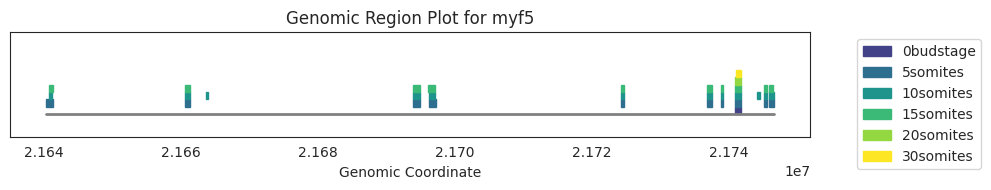

In [118]:
plot_CCANs_genomic_loci(list_mapped_peaks, gene_name="myf5", timepoints=timepoints, colordict=color_dict, 
                        save_fig=True, figpath=figpath)

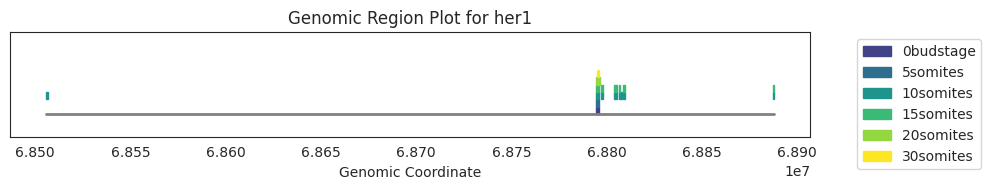

In [119]:
plot_CCANs_genomic_loci(list_mapped_peaks, gene_name="her1", timepoints=timepoints, colordict=color_dict, 
                        save_fig=True, figpath=figpath)

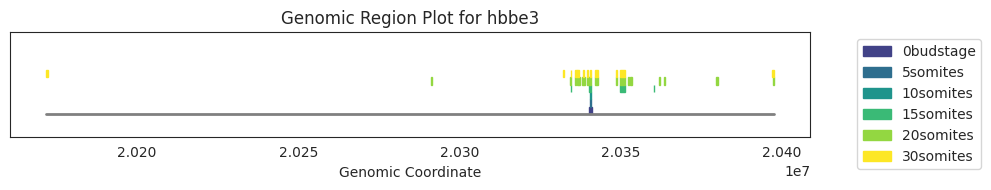

In [90]:
plot_CCANs_genomic_loci(list_mapped_peaks, gene_name="hbbe3", timepoints=timepoints, colordict=color_dict, 
                        save_fig=True, figpath=figpath)

hbbe3


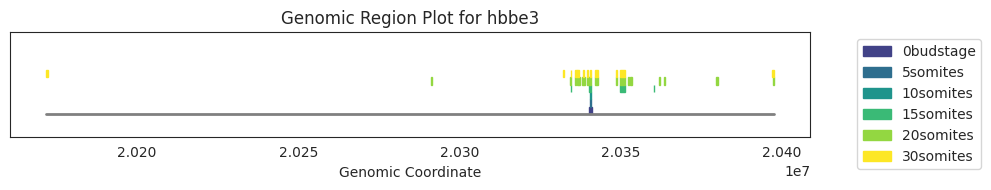

tbx2b


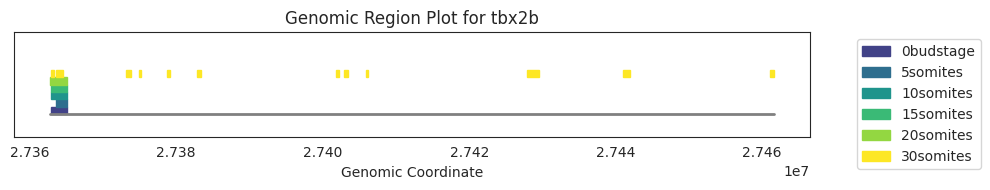

hbbe1.1


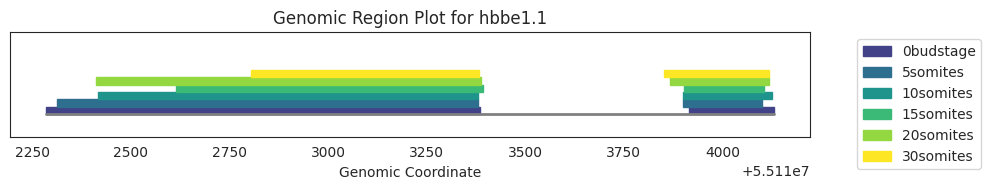

hoxc1a


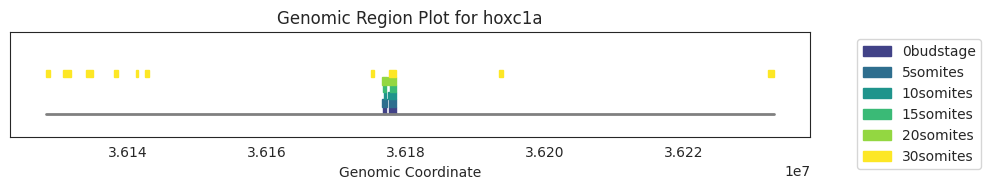

myog


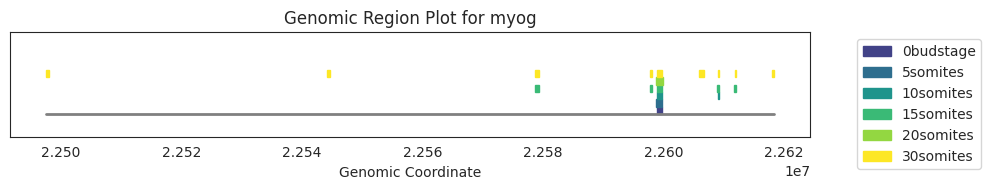

hoxc4a


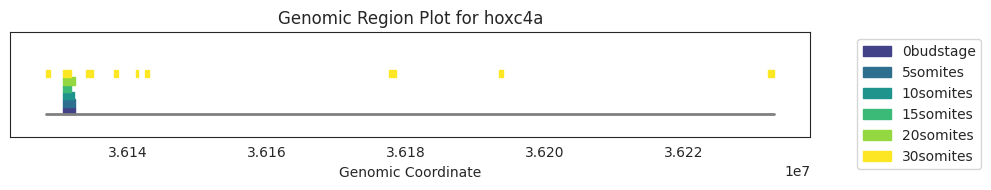

slc4a1a


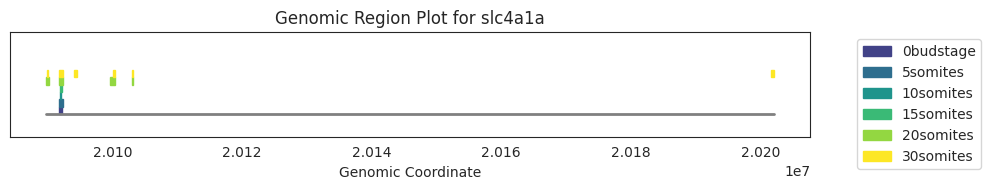

hoxc6b


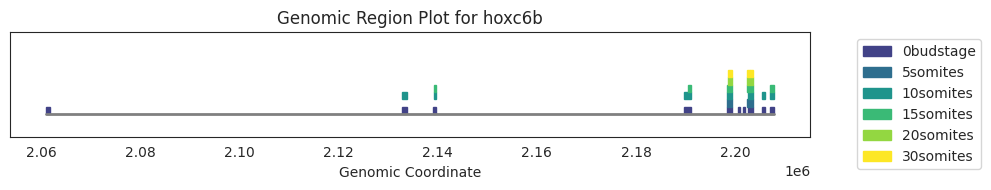

myf5


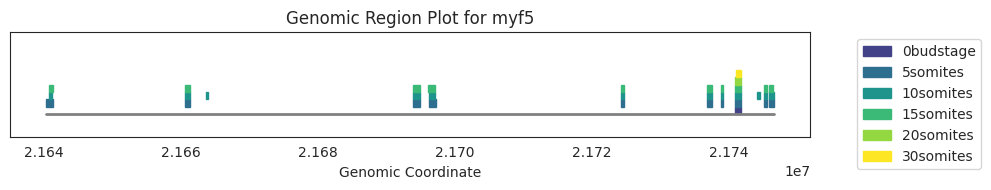

tbx6


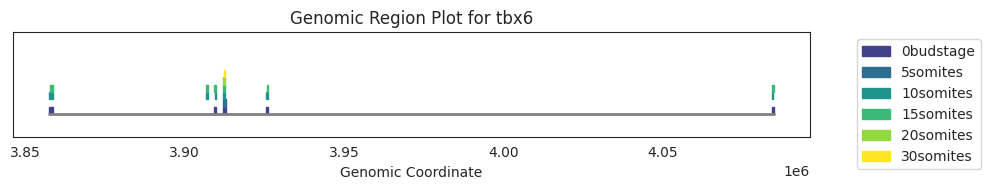

hoxa10b


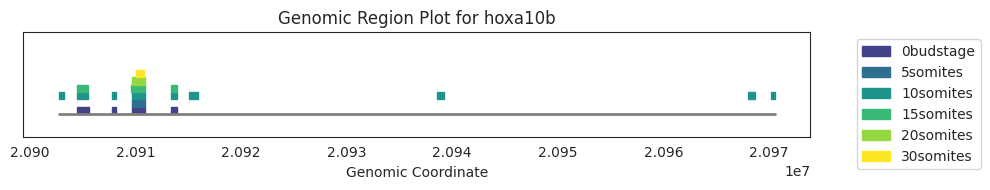

cdx4


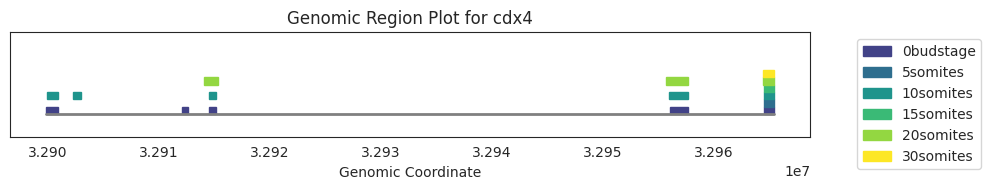

In [93]:
list_genes_dynamic_CCNAs = ["hbbe3","tbx2b","hbbe1.1","hoxc1a","myog","hoxc4a","slc4a1a", # increasing CCANs over time
                            "hoxc6b","myf5","tbx6","hoxa10b","cdx4"] # decreasing CCANs over time

for gene in list_genes_dynamic_CCNAs:
    print(gene)
    plot_CCANs_genomic_loci(list_mapped_peaks, gene_name=gene, timepoints=timepoints, colordict=color_dict, 
                        save_fig=True, figpath=figpath)

### Visualize the number of active enhancers (peaks that are highly co-accessible with TSS, including TSS)

- heatmap (genes-by-number of enhancers)

In [122]:
master_df.drop("TDR119reseq_cicero", axis=1, inplace=True)
master_df

,TDR126_cicero,TDR127_cicero,TDR128_cicero,TDR118reseq_cicero,TDR125reseq_cicero,TDR124reseq_cicero
gene_short_name,,,,,,
LOC100001344,1,1,1,1,1,1
LOC100001444,1,1,1,1,1,2
LOC100003140,1,1,1,1,1,1
LOC100141479,1,1,1,1,1,1
LOC100148066,1,1,1,1,1,1
...,...,...,...,...,...,...
zw10,1,1,1,1,1,1
zwi,2,2,2,1,1,1
zwilch,2,2,2,2,2,1


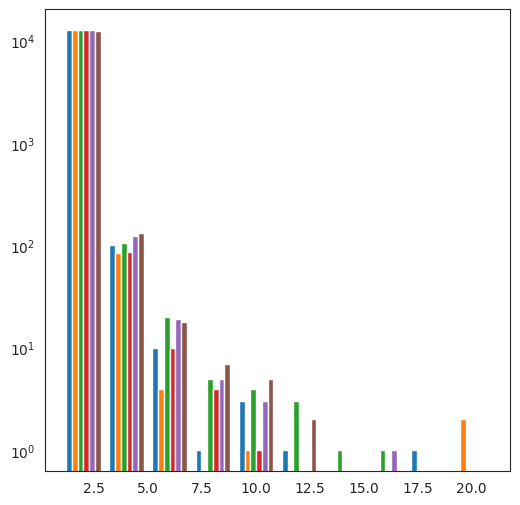

In [125]:
plt.hist(master_df)
plt.yscale("log")
plt.show()

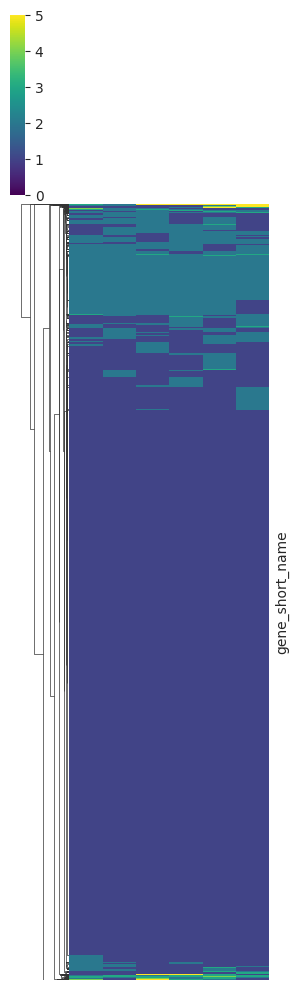

In [132]:
# first timepoint (0 somite/budstage)
df_counts = master_df

g1 = sns.clustermap(df_counts, method='average', metric='euclidean', cmap='viridis', standard_scale=None,
                row_cluster=True, col_cluster=False, 
                xticklabels=False, yticklabels=False, 
                figsize=(3, 10),  # Adjust the figsize to fit your data
                vmax=5, vmin=0)

# Access the axes for annotation
heatmap_ax = g1.ax_heatmap

# Determine the size of the heatmap for proper annotation placement
heatmap_size = heatmap_ax.get_window_extent().transformed(plt.gcf().dpi_scale_trans.inverted())

plt.show()

In [130]:
import sys
sys.setrecursionlimit(10000)  # Increase the recursion limit


### plot the peak-peak connections (cicero::plot_connections)

In [51]:
peaks = df_peak_list.x.values
print("the number of peaks: " + str(len(peaks)))

# add "chr" in front of each peak element for formatting (CellOracle genome reference)
peaks = "chr" + peaks

# reformat the peaks (replace the "-" with "_")
peaks = [s.replace("-","_") for s in peaks]
peaks = np.array(peaks)
peaks

the number of peaks: 485357


array(['chr1_3427_4032', 'chr1_4473_6136', 'chr1_11020_12944', ...,
       'chr9_56400365_56401096', 'chr9_56411957_56412701',
       'chr9_56433462_56434391'], dtype='<U23')

In [52]:
tss_annotated = ma.get_tss_info(peak_str_list=peaks, ref_genome="danRer11")
tss_annotated

que bed peaks: 485357
tss peaks in que: 15837


,chr,start,end,gene_short_name,strand
0,chr18,48530192,48530408,kcnj1a.2,-
1,chr10,34032548,34033635,rfc3,-
2,chr16,22864519,22865101,flad1,+
3,chr16,22865506,22866282,flad1,+
4,chr12,46739918,46740354,plaub,+
...,...,...,...,...,...
15832,chr5,38096745,38097727,si:ch211-284e13.5,+
15833,chr5,70345138,70346554,pappaa,+
15834,chr13,31377081,31377415,ubtd1a,-
15835,chr13,31378144,31378974,ubtd1a,-


In [78]:
threshold_coaccess = 0.5  # Example threshold value
filtered_peak_pairs = subset_df_peak_pairs[subset_df_peak_pairs['coaccess'] >= threshold_coaccess]

filtered_peak_pairs.head()

,Peak1,Peak2,coaccess
6637572,4-21535200-21535504,4-21740908-21741730,0.571323
6766373,4-21634141-21634407,4-21740908-21741730,0.514520
6769173,4-21637424-21638159,4-21740908-21741730,0.514169
6771973,4-21640719-21641306,4-21740908-21741730,0.827774
6791572,4-21660681-21661348,4-21740908-21741730,0.812632


In [84]:
# First, compute the start and end positions for both Peak1 and Peak2
filtered_peak_pairs = compute_start_end(filtered_peak_pairs)
filtered_peak_pairs.head()

,Peak1,Peak2,coaccess,Peak1_chrom,Peak1_start,Peak1_end,Peak2_chrom,Peak2_start,Peak2_end
6637572,4-21535200-21535504,4-21740908-21741730,0.571323,4,21535200,21535504,4,21740908,21741730
6766373,4-21634141-21634407,4-21740908-21741730,0.514520,4,21634141,21634407,4,21740908,21741730
6769173,4-21637424-21638159,4-21740908-21741730,0.514169,4,21637424,21638159,4,21740908,21741730
6771973,4-21640719-21641306,4-21740908-21741730,0.827774,4,21640719,21641306,4,21740908,21741730
6791572,4-21660681-21661348,4-21740908-21741730,0.812632,4,21660681,21661348,4,21740908,21741730


In [97]:
from matplotlib.path import Path
import matplotlib.patches as patches

# Your existing function to extract start and end positions, already suitable for the DataFrame structure
def compute_start_end(df):
    """Extract start and end positions from Peak columns."""
    for peak_col in ['Peak1', 'Peak2']:
        # Split the 'Peak' columns into chromosome, start, and end
        df[[f'{peak_col}_chrom', f'{peak_col}_start', f'{peak_col}_end']] = df[peak_col].str.split('-', expand=True)
        df[f'{peak_col}_start'] = pd.to_numeric(df[f'{peak_col}_start'])
        df[f'{peak_col}_end'] = pd.to_numeric(df[f'{peak_col}_end'])
    return df

def plot_peaks(df, ax, y_level):
    """Plot each peak as a line on the axis."""
    for _, row in df.iterrows():
        # Plotting Peak1
        ax.hlines(y=y_level, xmin=row['Peak1_start'], xmax=row['Peak1_end'], color='blue', lw=2)
        # Plotting Peak2
        ax.hlines(y=y_level + 0.05, xmin=row['Peak2_start'], xmax=row['Peak2_end'], color='red', lw=2)
        

# Updated function to plot lines representing peak connections
def plot_peak_connections(df, ax, y_level, linewidth_scale=1):
    """Plot lines representing connections between peaks with linewidth based on coaccess score."""
    for _, row in df.iterrows():
        linewidth = row['coaccess'] * linewidth_scale  # Scale the linewidth based on coaccess score
        # Plot a line between Peak1 and Peak2
        ax.plot([row['Peak1_start'], row['th']], [y_level, y_level], 
                color='blue', linestyle='-', linewidth=linewidth)

def plot_bezier_curve(ax, start, end, y_level, coaccess_score, linewidth_scale=1):
    """Plot a bezier curve between two points with the given coaccessibility score."""
    # Control points for the bezier curve
    vertices = np.array([
        [start, y_level],
        [np.mean([start, end]), y_level + 0.05],  # This 0.05 determines the height of the curve
        [end, y_level]
    ])
    
    # Bezier curve codes
    codes = [Path.MOVETO, Path.CURVE3, Path.CURVE3]
    path = Path(vertices, codes)
    
    # Scale the linewidth by the coaccess score
    linewidth = coaccess_score * linewidth_scale
    
    # Create a patch from the bezier path
    patch = patches.PathPatch(path, facecolor='none', lw=linewidth, edgecolor='blue', alpha=0.5)
    ax.add_patch(patch)
    
    print(f"Plotting curve: start={start}, end={end}, coaccess={coaccess_score}, linewidth={linewidth}")

def plot_coaccess_curves(df, ax, y_level, linewidth_scale=1):
    """Plot bezier curves representing co-accessibility between peaks."""
    for _, row in df.iterrows():
        # Plot a bezier curve for each pair
        plot_bezier_curve(ax, 
                          start=row['Peak1_start'], 
                          end=row['Peak2_start'], 
                          y_level=y_level, 
                          coaccess_score=row['coaccess'], 
                          linewidth_scale=linewidth_scale)
        


In [93]:
filtered_peak_pairs.head()

,Peak1,Peak2,coaccess,Peak1_chrom,Peak1_start,Peak1_end,Peak2_chrom,Peak2_start,Peak2_end
6637572,4-21535200-21535504,4-21740908-21741730,0.571323,4,21535200,21535504,4,21740908,21741730
6766373,4-21634141-21634407,4-21740908-21741730,0.514520,4,21634141,21634407,4,21740908,21741730
6769173,4-21637424-21638159,4-21740908-21741730,0.514169,4,21637424,21638159,4,21740908,21741730
6771973,4-21640719-21641306,4-21740908-21741730,0.827774,4,21640719,21641306,4,21740908,21741730
6791572,4-21660681-21661348,4-21740908-21741730,0.812632,4,21660681,21661348,4,21740908,21741730


4-21740908-21741730
Genomic coordinates range: 21535200 to 21924189
Plotting curve: start=21535200, end=21740908, coaccess=0.571323213010914, linewidth=5.713232130109141
Plotting curve: start=21634141, end=21740908, coaccess=0.514519529105218, linewidth=5.145195291052181
Plotting curve: start=21637424, end=21740908, coaccess=0.514169215420213, linewidth=5.14169215420213
Plotting curve: start=21640719, end=21740908, coaccess=0.827773800208028, linewidth=8.27773800208028
Plotting curve: start=21660681, end=21740908, coaccess=0.812632462414244, linewidth=8.126324624142441
Plotting curve: start=21663629, end=21740908, coaccess=0.786597825954144, linewidth=7.865978259541439
Plotting curve: start=21665965, end=21740908, coaccess=0.615471779828977, linewidth=6.15471779828977
Plotting curve: start=21668219, end=21740908, coaccess=0.539662746122043, linewidth=5.39662746122043
Plotting curve: start=21669787, end=21740908, coaccess=0.634691307573128, linewidth=6.34691307573128
Plotting curve: sta

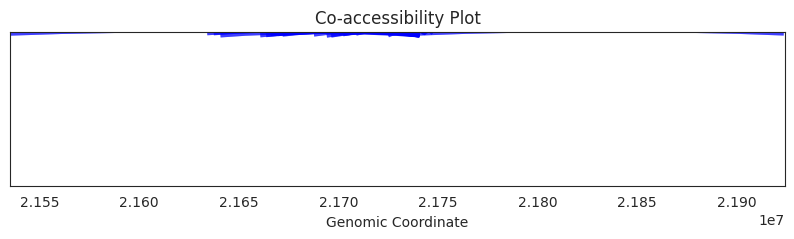

In [94]:
# Step 1: Subset the peak_pairs for a given gene (geneA)
gene = "myf5"
# peak_pairs_gene_selected = peak_pairs[peak_pairs['gene'] == gene]
# extract the peak for the gene's TSS
tss_gene_selected = tss_annotated[tss_annotated.gene_short_name == gene].iloc[0]

# Format the 'chr', 'start', and 'end' into the desired string format.
formatted_peak = f"{tss_gene_selected['chr'].replace('chr', '')}-{tss_gene_selected['start']}-{tss_gene_selected['end']}"
print(formatted_peak)

subset_df_peak_pairs = df_peak_pairs[
    (df_peak_pairs['Peak1'] == formatted_peak) | 
    (df_peak_pairs['Peak2'] == formatted_peak)
]

# Step 2: Filter the dataframe using coaccess threshold (threshold_coaccess)
threshold_coaccess = 0.5  # Example threshold value
filtered_peak_pairs = subset_df_peak_pairs[subset_df_peak_pairs['coaccess'] >= threshold_coaccess]

# First, compute the start and end positions for both Peak1 and Peak2
filtered_peak_pairs = compute_start_end(filtered_peak_pairs)

# Check if there's any data to plot
if filtered_peak_pairs.empty:
    print("No data to plot after filtering.")
else:
    # Print min and max genomic coordinates to help set x-axis limits
    genomic_start = min(filtered_peak_pairs['Peak1_start'].min(), filtered_peak_pairs['Peak2_start'].min())
    genomic_end = max(filtered_peak_pairs['Peak1_end'].max(), filtered_peak_pairs['Peak2_end'].max())
    print(f"Genomic coordinates range: {genomic_start} to {genomic_end}")



# # Now create a plot with bezier curves for connections between peaks
# fig, ax = plt.subplots(figsize=(10, 2))
# # The y-axis level where the curves will be plotted, arbitrary choice here, you can adjust as needed
# y_level = 1
# # Scale factor for linewidth, you might need to adjust this based on your specific 'coaccess' scores range
# linewidth_scale = 10  
# plot_coaccess_curves(filtered_peak_pairs, ax, y_level, linewidth_scale)

# # Setting the labels and title
# ax.set_xlabel('Genomic Coordinate')
# ax.set_title('Co-accessibility Plot')

# # Removing y-axis as it's not informative for this plot
# ax.get_yaxis().set_visible(False)

# # Set the x-axis limits if necessary
# ax.set_xlim(genomic_start, genomic_end)

# plt.show()

Plotting curve: start=21535200, end=21740908, coaccess=0.571323213010914, linewidth=5.713232130109141
Plotting curve: start=21634141, end=21740908, coaccess=0.514519529105218, linewidth=5.145195291052181
Plotting curve: start=21637424, end=21740908, coaccess=0.514169215420213, linewidth=5.14169215420213
Plotting curve: start=21640719, end=21740908, coaccess=0.827773800208028, linewidth=8.27773800208028
Plotting curve: start=21660681, end=21740908, coaccess=0.812632462414244, linewidth=8.126324624142441
Plotting curve: start=21663629, end=21740908, coaccess=0.786597825954144, linewidth=7.865978259541439
Plotting curve: start=21665965, end=21740908, coaccess=0.615471779828977, linewidth=6.15471779828977
Plotting curve: start=21668219, end=21740908, coaccess=0.539662746122043, linewidth=5.39662746122043
Plotting curve: start=21669787, end=21740908, coaccess=0.634691307573128, linewidth=6.34691307573128
Plotting curve: start=21671889, end=21740908, coaccess=0.706672512104232, linewidth=7.0

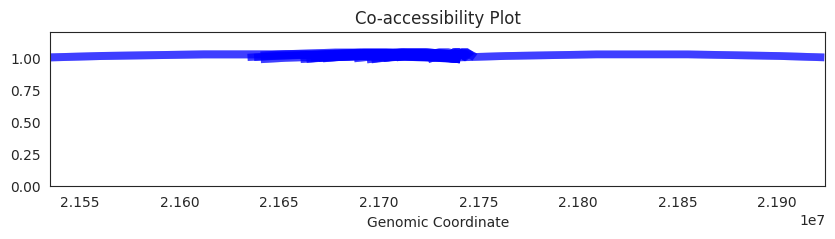

In [96]:
# Now create a plot with bezier curves for connections between peaks
fig, ax = plt.subplots(figsize=(10, 2))
y_level = 1  # The y-axis level where the peaks are plotted
curve_height = 0.1  # Additional space above y_level to fit the curve
linewidth_scale = 10  # Scale factor for linewidth
plot_coaccess_curves(filtered_peak_pairs, ax, y_level, linewidth_scale)

# Setting the labels and title
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Co-accessibility Plot')

# Set the y-axis limits to include the bezier curves
ax.set_ylim(0, y_level + curve_height + 0.1)  # Adding some padding above the highest curve

# Set the x-axis limits to include all genomic coordinates
genomic_start = min(filtered_peak_pairs['Peak1_start'].min(), filtered_peak_pairs['Peak2_start'].min())
genomic_end = max(filtered_peak_pairs['Peak1_end'].max(), filtered_peak_pairs['Peak2_end'].max())
ax.set_xlim(genomic_start, genomic_end)

plt.show()

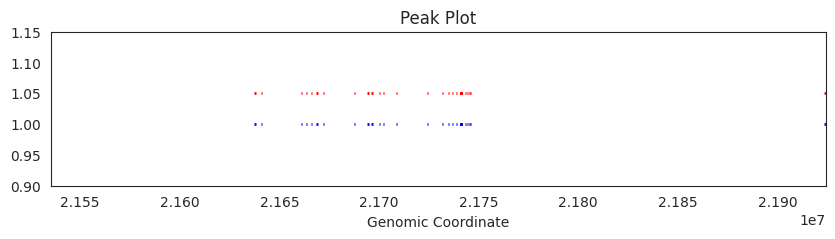

In [100]:
# Now create a plot with peaks
fig, ax = plt.subplots(figsize=(10, 2))
y_level = 1  # The y-axis level where the peaks are plotted
plot_peaks(filtered_peak_pairs, ax, y_level)

# Setting the labels and title
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Peak Plot')

# Set the y-axis limits to include the peaks
ax.set_ylim(0.9, y_level + 0.15)  # Add some space above and below the peaks

# Set the x-axis limits to include all genomic coordinates
genomic_start = min(filtered_peak_pairs['Peak1_start'].min(), filtered_peak_pairs['Peak2_start'].min())
genomic_end = max(filtered_peak_pairs['Peak1_end'].max(), filtered_peak_pairs['Peak2_end'].max())
ax.set_xlim(genomic_start, genomic_end)

plt.show()

In [35]:
def compute_start_end(df):
    """Extract start and end positions from Peak columns."""
    for peak_col in ['Peak1', 'Peak2']:
        # Split the 'Peak' columns into chromosome, start, and end
        df[[f'{peak_col}_chrom', f'{peak_col}_start', f'{peak_col}_end']] = df[peak_col].str.split('-', expand=True)
        df[f'{peak_col}_start'] = pd.to_numeric(df[f'{peak_col}_start'])
        df[f'{peak_col}_end'] = pd.to_numeric(df[f'{peak_col}_end'])
    return df

def plot_peaks(df, ax, y_level, color, label=None):
    """Plot each peak as a line on the axis."""
    for _, row in df.iterrows():
        ax.plot([row['Peak1_start'], row['Peak1_end']], [y_level, y_level], color=color, marker='|', linestyle='-', linewidth=2, label=label)
        ax.plot([row['Peak2_start'], row['Peak2_end']], [y_level, y_level], color=color, marker='|', linestyle='-', linewidth=2)

def plot_genomic_regions(CCANs, excluded_peaks, save_fig=False, figpath=None):
    """Plot genomic regions with special marking for the excluded_peak."""
    fig, ax = plt.subplots(figsize=(10, 2))

    # Color for regular peaks and TSS
    # Use Seaborn to get "Set2" colors
    set2_palette = sns.color_palette("Set2")
    colors = set2_palette[:len(CCANs)]  # Get as many colors as there are datasets
    tss_color = 'red'  # Color for TSS peaks
    
    for index, (df, excluded_peak) in enumerate(zip(CCANs, excluded_peaks)):
        df = compute_start_end(df)
        dataset_color = colors[index]  # Get color from "Set2" palette
        
        # Loop through each peak column
        for peak_col in ['Peak1', 'Peak2']:
            # Determine regular and TSS peaks based on exclusion criteria
            regular_peaks = df[~df[peak_col].isin(excluded_peak)]
            tss_peaks = df[df[peak_col].isin(excluded_peak)]

            # Plot regular peaks with dataset-specific color from "Set2"
            plot_peaks(regular_peaks, ax, 1 + index * 0.1, dataset_color)
            
            # Plot TSS peaks, only label the first occurrence
            if index == 0 and peak_col == 'Peak1':
                plot_peaks(tss_peaks, ax, 1 + index * 0.1, tss_color, "TSS")
            else:
                plot_peaks(tss_peaks, ax, 1 + index * 0.1, tss_color)
#         # Plot regular peaks
#         for peak_col in ['Peak1', 'Peak2']:
#             regular_peaks = df[~df[peak_col].isin(excluded_peak)]
#             tss_peaks = df[df[peak_col].isin(excluded_peak)]
            
#             plot_peaks(regular_peaks, ax, 1 + index * 0.1, regular_color)
#             plot_peaks(tss_peaks, ax, 1 + index * 0.1, tss_color, "TSS" if peak_col == 'Peak1' else None)

    ax.set_ylim(0.7, 1.5)
    ax.set_yticks([])
    ax.set_xlabel('Genomic Coordinate')
    ax.set_title('Genomic Region Plot')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles[:2], ["Dataset 1", "TSS"] + ["Dataset 2"] * (len(CCANs) - 1))

    plt.tight_layout()

    if save_fig and figpath:
        plt.savefig(figpath + "genomic_regions_plot.png")
        plt.savefig(figpath + "genomic_regions_plot.pdf")

    plt.show()

In [55]:
# colormap - just define at the beginning (this can be replaced)
# Define the timepoints
all_timepoints = ["0budstage", "5somites", "10somites", "15somites", "20somites", "30somites"]

# Load the "viridis" colormap
viridis = plt.cm.get_cmap('viridis', 256)

# Select a subset of the colormap to ensure that "30 somites" is yellow
# You can adjust the start and stop indices to shift the colors
start = 50
stop = 256
colors = viridis(np.linspace(start/256, stop/256, len(all_timepoints)))

# Create a dictionary to map timepoints to colors
color_dict = dict(zip(all_timepoints, colors))
color_dict

{'0budstage': array([0.255645, 0.260703, 0.528312, 1.      ]),
 '5somites': array([0.180629, 0.429975, 0.557282, 1.      ]),
 '10somites': array([0.123463, 0.581687, 0.547445, 1.      ]),
 '15somites': array([0.226397, 0.728888, 0.462789, 1.      ]),
 '20somites': array([0.575563, 0.844566, 0.256415, 1.      ]),
 '30somites': array([0.993248, 0.906157, 0.143936, 1.      ])}

In [56]:
def plot_CCANs_genomic_loci(CCANs, timepoints, gene_name, colordict, 
                            save_fig=False, figpath = None):
    """
    Description: 
    This function takes a list of CCANs (dataframes for each timepoint), 
    plots the genomic region with CCANs for each timepoint for "gene_name".
    
    Parameters:
    1) gene_name: Name of the gene, i.e. "myf5", "her1"
    2) CCANs: A list of dataframes (one dataframe for each timepoint), i.e. [df1, df2, df3]
    3) timepoints: A list of timepoint labels corresponding to each dataframe in CCANs
    4) colordict: A dictionary of {timepoints:colors (viridis)}
    """
    
    if len(CCANs) != len(timepoints):
        raise ValueError("The number of CCANs dataframes and timepoints labels must be equal")

    # generate a figure object    
    fig, ax = plt.subplots(figsize=(10, 2))
    
    genomic_start, genomic_end = float('inf'), 0

    for index, (df, stage) in enumerate(zip(CCANs, timepoints)):
        df = df[df.gene_short_name == gene_name]
        df = compute_start_end(df)
        
        genomic_start = min(genomic_start, df['start'].min())
        genomic_end = max(genomic_end, df['end'].max())
        
        plot_peaks(df, ax, 1 + index*0.1, colordict[stage], stage)
    
    ax.plot([genomic_start, genomic_end], [1, 1], color='grey', linewidth=2)
    
    ax.set_ylim(0.7, 1 + len(CCANs)*0.1 + 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Genomic Coordinate')
    ax.set_title(f'Genomic Region Plot for {gene_name}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    if save_fig==True:
        plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".png")
        plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".pdf")
    
    plt.show()

KeyError: 'Peak1'

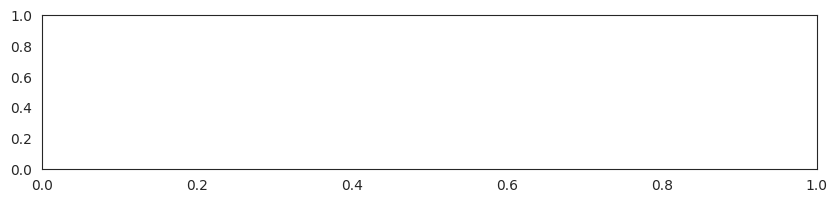

In [60]:
# Define the gene name
gene_name = "myf5"

# define an empty list to save the TSS-mapped peaks
list_mapped_peaks = []

for dataset in datasets_cicero.keys():
    list_mapped_peaks.append(datasets_cicero[dataset]["filtered_peaks"])

        
plot_CCANs_genomic_loci(list_mapped_peaks,
                        gene_name="myf5", 
                        timepoints=["0budstage","5somites","10somites","15somites","15somites","20somites","30somites"], 
                        colordict=color_dict)


## comparison of TSS-mapped peaks (highly co-accessible with TSS) between biological replicates (TDR118 and TDR119)


In [106]:
def compute_start_end(df):
    """Extract start and end positions from Peak columns."""
    for peak_col in ['Peak1', 'Peak2']:
        # Split the 'Peak' columns into chromosome, start, and end
        df[[f'{peak_col}_chrom', f'{peak_col}_start', f'{peak_col}_end']] = df[peak_col].str.split('-', expand=True)
        df[f'{peak_col}_start'] = pd.to_numeric(df[f'{peak_col}_start'])
        df[f'{peak_col}_end'] = pd.to_numeric(df[f'{peak_col}_end'])
    return df

def plot_peaks(df, ax, y_level, color, label=None):
    """Plot each peak as a line on the axis."""
    for _, row in df.iterrows():
        ax.plot([row['Peak1_start'], row['Peak1_end']], [y_level, y_level], color=color, marker='|', linestyle='-', linewidth=2, label=label)
        ax.plot([row['Peak2_start'], row['Peak2_end']], [y_level, y_level], color=color, marker='|', linestyle='-', linewidth=2)

def plot_genomic_regions(CCANs, excluded_peaks, save_fig=False, figpath=None):
    """Plot genomic regions with special marking for the excluded_peak."""
    fig, ax = plt.subplots(figsize=(10, 2))

    # Color for regular peaks and TSS
    # Use Seaborn to get "Set2" colors
    set2_palette = sns.color_palette("Set2")
    colors = set2_palette[:len(CCANs)]  # Get as many colors as there are datasets
    tss_color = 'red'  # Color for TSS peaks
    
    for index, (df, excluded_peak) in enumerate(zip(CCANs, excluded_peaks)):
        df = compute_start_end(df)
        dataset_color = colors[index]  # Get color from "Set2" palette
        
        # Loop through each peak column
        for peak_col in ['Peak1', 'Peak2']:
            # Determine regular and TSS peaks based on exclusion criteria
            regular_peaks = df[~df[peak_col].isin(excluded_peak)]
            tss_peaks = df[df[peak_col].isin(excluded_peak)]

            # Plot regular peaks with dataset-specific color from "Set2"
            plot_peaks(regular_peaks, ax, 1 + index * 0.1, dataset_color)
            
            # Plot TSS peaks, only label the first occurrence
            if index == 0 and peak_col == 'Peak1':
                plot_peaks(tss_peaks, ax, 1 + index * 0.1, tss_color, "TSS")
            else:
                plot_peaks(tss_peaks, ax, 1 + index * 0.1, tss_color)
#         # Plot regular peaks
#         for peak_col in ['Peak1', 'Peak2']:
#             regular_peaks = df[~df[peak_col].isin(excluded_peak)]
#             tss_peaks = df[df[peak_col].isin(excluded_peak)]
            
#             plot_peaks(regular_peaks, ax, 1 + index * 0.1, regular_color)
#             plot_peaks(tss_peaks, ax, 1 + index * 0.1, tss_color, "TSS" if peak_col == 'Peak1' else None)

    ax.set_ylim(0.7, 1.5)
    ax.set_yticks([])
    ax.set_xlabel('Genomic Coordinate')
    ax.set_title('Genomic Region Plot')
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles[:2], ["Dataset 1", "TSS"] + ["Dataset 2"] * (len(CCANs) - 1))

    plt.tight_layout()

    if save_fig and figpath:
        plt.savefig(figpath + "genomic_regions_plot.png")
        plt.savefig(figpath + "genomic_regions_plot.pdf")

    plt.show()


In [202]:
def compute_start_end(df):
    """Extract start and end positions from Peak columns."""
    for peak_col in ['Peak1', 'Peak2']:
        df[[f'{peak_col}_chrom', f'{peak_col}_start', f'{peak_col}_end']] = df[peak_col].str.split('-', expand=True)
        df[f'{peak_col}_start'] = pd.to_numeric(df[f'{peak_col}_start'])
        df[f'{peak_col}_end'] = pd.to_numeric(df[f'{peak_col}_end'])
    return df

def plot_peaks(df, ax, y_level, color, label=None):
    """Plot each peak as a line on the axis."""
    for _, row in df.iterrows():
        ax.plot([row['Peak1_start'], row['Peak1_end']], [y_level, y_level], color=color, marker='|', linestyle='-', linewidth=2, label=label)
        label = None  # Ensure label is only used once

def plot_genomic_regions(CCANs, excluded_peaks, dataset_labels, save_fig=False, figpath=None):
    """Plot genomic regions with special marking for excluded peaks using 'Set2' colors and include dataset labels."""
    fig, ax = plt.subplots(figsize=(10, 2))

    # Use Seaborn to get "Set2" colors
    set2_palette = sns.color_palette("Set2")
    colors = set2_palette[:len(CCANs)]  # Assign colors to datasets

    tss_color = 'red'  # Color for TSS peaks
    tss_label_added = False  # Flag to ensure TSS label is added only once

    for index, df in enumerate(CCANs):
        df = compute_start_end(df)
        dataset_color = colors[index]  # Color from "Set2" palette

        # Plot peaks, marking TSS peaks differently
        for _, row in df.iterrows():
            for peak_col in ['Peak1', 'Peak2']:
                is_tss_peak = row[peak_col] in excluded_peaks
                color = tss_color if is_tss_peak else dataset_color
                peak_label = "TSS" if is_tss_peak and not tss_label_added else None
                
                if peak_label:  # Mark TSS label as added after its first use
                    tss_label_added = True

                start, end = row[f'{peak_col}_start'], row[f'{peak_col}_end']
                ax.plot([start, end], [1 + index * 0.1, 1 + index * 0.1], color=color, marker='|', linestyle='-', linewidth=2, label=peak_label if peak_col == 'Peak1' else None)

        # Add a label for the dataset
        ax.plot([], [], color=dataset_color, marker='|', linestyle='-', linewidth=2, label=dataset_labels[index])

    ax.set_ylim(0.7, 2)
    ax.set_yticks([])
    ax.set_xlabel('Genomic Coordinate')
    ax.set_title('Genomic Region Plot')
    ax.legend()

    plt.tight_layout()

    if save_fig and figpath:
        plt.savefig(figpath + "genomic_regions_plot.png")
        plt.savefig(figpath + "genomic_regions_plot.pdf")

    plt.show()


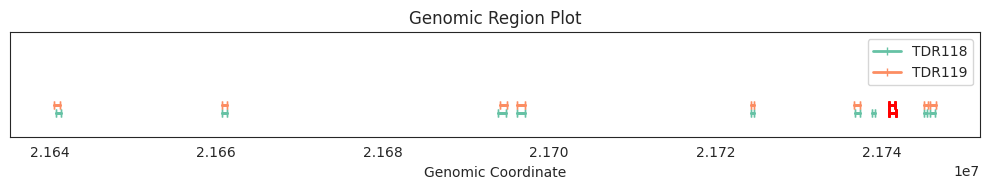

In [203]:
# Example usage
plot_genomic_regions([peaks_myf5_TDR118, peaks_myf5_TDR119], 
                     [TSS_118, TSS_TDR119], ["TDR118","TDR119"])

In [11]:
# # import the TSS-mapped (linked) peaks
# mapped_peaks_15somites = pd.read_csv(cicero_output_path + "/TDR118reseq_cicero/03_TDR118reseq_processed_peak_file_danRer11.csv", index_col=0)
# mapped_peaks_15somites_rep2 = pd.read_csv(cicero_output_path + "TDR119reseq_cicero/03_TDR119reseq_processed_peak_file_danRer11.csv", index_col=0)

# mapped_peaks_20somites = pd.read_csv(cicero_output_path + "TDR125reseq_cicero/03_TDR125reseq_processed_peak_file_danRer11.csv", index_col=0)

# mapped_peaks_30somites = pd.read_csv(cicero_output_path + "TDR124reseq_cicero/03_TDR124reseq_processed_peak_file_danRer11.csv", index_col=0)

# mapped_peaks_0somites = pd.read_csv(cicero_output_path + "TDR126_cicero/03_TDR126_processed_peak_file_danRer11.csv", index_col=0)

# mapped_peaks_5somites = pd.read_csv(cicero_output_path + "TDR127_cicero/03_TDR127_processed_peak_file_danRer11.csv", index_col=0)

# mapped_peaks_10somites = pd.read_csv(cicero_output_path + "TDR128_cicero/03_TDR128_processed_peak_file_danRer11.csv", index_col=0)


In [12]:
# print("the number of cis-regulatory elements in 0 somites:", len(mapped_peaks_0somites))
# print("the number of cis-regulatory elements in 5 somites:", len(mapped_peaks_5somites))
# print("the number of cis-regulatory elements in 10 somites:", len(mapped_peaks_10somites))
# print("the number of cis-regulatory elements in 15 somites:", len(mapped_peaks_15somites))
# print("the number of cis-regulatory elements in 15 somites (rep2):", len(mapped_peaks_15somites_rep2))
# print("the number of cis-regulatory elements in 20 somites:", len(mapped_peaks_20somites))
# print("the number of cis-regulatory elements in 30 somites:", len(mapped_peaks_30somites))

the number of cis-regulatory elements in 0 somites: 16011
the number of cis-regulatory elements in 5 somites: 16145
the number of cis-regulatory elements in 10 somites: 15838
the number of cis-regulatory elements in 15 somites: 15748
the number of cis-regulatory elements in 15 somites (rep2): 15587
the number of cis-regulatory elements in 20 somites: 16383
the number of cis-regulatory elements in 30 somites: 15793


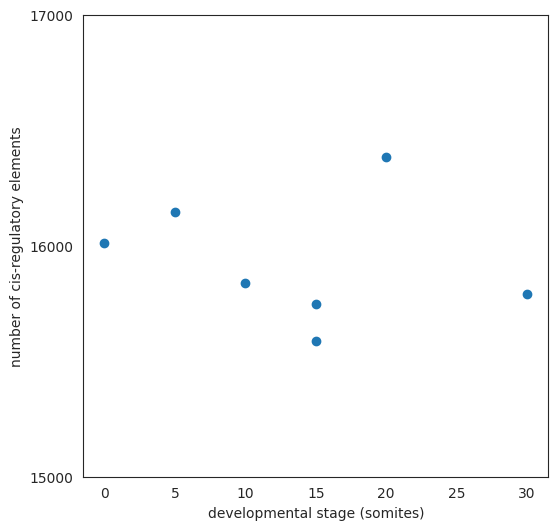

In [15]:
# %matplotlib inline
# plt.scatter(x=[0, 5, 10, 15, 15, 20, 30], 
#             y=[len(mapped_peaks_0somites), len(mapped_peaks_5somites), len(mapped_peaks_10somites),
#                 len(mapped_peaks_15somites), len(mapped_peaks_15somites_rep2),
#                 len(mapped_peaks_20somites), len(mapped_peaks_30somites)])

# # Add titles and labels
# plt.title('')
# plt.xlabel('developmental stage (somites)')
# plt.ylabel('number of cis-regulatory elements')
# plt.xticks([0, 5, 10, 15, 20, 25, 30])
# plt.yticks([15000, 16000, 17000])
# plt.ylim([15000, 17000])

# plt.savefig(figpath + "num_CCANs_over_time_0_30_somites.pdf")
# plt.savefig(figpath + "num_CCANs_over_time_0_30_somites.png")

# plt.show()

## Note:

- There's a trend that the number of active cis-regulatory elements decreasing as the development progresses.
- At the gene level, there are genes whose cis-regulatory elements increases or decreases. We will take a closer look at this in the following sections.

# Step 2. EDA on the dataframes

- **[DONE]1)** number of cis-regulatory elements at each timepoint (if we have more than two timepoints, we can assess the temporal dependence.)

- **[DONE]2)** Overlapping peaks between the two timepoints (venn-diagram?): unique peaks from the peaks1 and peaks2, respetively.

    - 2-1) A pairwise comparison between the CCANs (15 vs 20, 15 vs 30, 15 vs 15 (replicates), 20 vs 30)
    

- **[Advanced]** Among selected peaks (like above), what are the TF motifs that are mapped to those peaks? Do we see any interesting regulatory relationships from those (time-dependent)?

- **[Advanced]** which peaks were detected in which cell-types? This will require us to link back to the Seurat/Signac object.

In [19]:
mapped_peaks_15somites.sort_values("gene_short_name")

,peak_id,gene_short_name
12363,chr5_33213880_33215451,LOC100001344
9914,chr2_15584553_15584752,LOC100001444
564,chr11_1088181_1088708,LOC100003140
9164,chr24_27423139_27424071,LOC100141479
3864,chr16_47202575_47203626,LOC100148066
...,...,...
4661,chr18_19455488_19456730,zwilch
4662,chr18_19457170_19457461,zwilch
6575,chr20_16173340_16174385,zyg11
3441,chr16_17345940_17346479,zyx


In [20]:
mapped_peaks_30somites.sort_values("gene_short_name")

,peak_id,gene_short_name
12447,chr5_33213949_33215461,LOC100001344
11299,chr3_49556929_49557422,LOC100001444
9943,chr2_15584428_15585162,LOC100001444
3270,chr15_463773_464114,LOC100002960
568,chr11_1088424_1088702,LOC100003140
...,...,...
7473,chr21_23045901_23046705,zw10
10855,chr3_21024880_21025371,zwi
4686,chr18_19455496_19456704,zwilch
6575,chr20_16173455_16174234,zyg11


## 15 somites vs 30 somites - Check some example genes:

- her1 (Segmentation gene)

In [21]:
mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name=="her1"]

,peak_id,gene_short_name
12854,chr5_68794300_68795260,her1
12855,chr5_68795698_68796292,her1


In [22]:
mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name=="her1"]

,peak_id,gene_short_name
12945,chr5_68794841_68795231,her1
12946,chr5_68795763_68796257,her1


In [23]:
mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name=="tbx16"]

,peak_id,gene_short_name
15037,chr8_51753337_51753860,tbx16
15038,chr8_51754474_51754715,tbx16


In [24]:
mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name=="tbx16"]

,peak_id,gene_short_name
15101,chr8_51753459_51753793,tbx16
15102,chr8_51754519_51754728,tbx16


In [25]:
# functions to extract the coordinates and compute the overlap between the two peaks

def extract_coordinates(peak_id):
    """Extract chromosome, start and end coordinates from peak_id."""
    chrom, start, end = peak_id.split('_')
    return chrom, int(start), int(end)

def has_overlap(peak1, peak2, threshold=10):
    """Check if two peaks have overlap based on a threshold."""
    chrom1, start1, end1 = extract_coordinates(peak1)
    chrom2, start2, end2 = extract_coordinates(peak2)
    
    # Check if they're on the same chromosome
    if chrom1 != chrom2:
        return False
    
    # Check for overlap
    overlap = max(0, min(end1, end2) - max(start1, start2))
    return overlap >= threshold

In [26]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_15somites
df2 = mapped_peaks_30somites

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_df1 = pd.DataFrame(unique_df1_peaks)
unique_df2 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in df1:")
print(unique_df1)

print("\nUnique peaks in df2:")
print(unique_df2)



Unique peaks in df1:
                      peak_id gene_short_name
0     chr22_10121651_10121995            rdh5
1     chr22_10215373_10215593          kctd6a
2     chr22_10571417_10571722  si:dkey-42i9.6
3     chr22_11595717_11596301           gnav1
4     chr22_11713943_11714426          crygs1
...                       ...             ...
1303  chr24_42003635_42003864          top1mt
1304    chr24_6260158_6260571           myo3a
1305    chr24_8731614_8731813          tfap2a
1306    chr24_8732242_8732736          tfap2a
1307    chr24_8888545_8888752          elovl2

[1308 rows x 2 columns]

Unique peaks in df2:
                      peak_id  gene_short_name
0     chr22_11534340_11534602              npb
1     chr22_11649246_11649513             dpp4
2     chr22_11775142_11775530            krt96
3     chr22_14102433_14102679            he1.3
4       chr22_1431810_1432594  si:dkeyp-53d3.6
...                       ...              ...
1064      chr24_743781_744004           stk17a
1065

In [27]:
unique_15_30 = unique_df1
unique_30_15 = unique_df2

In [28]:
unique_15_30.value_counts("gene_short_name")

gene_short_name
zgc:103755    3
crhr2         3
prkchb        3
skap1         3
ckmt2a        2
             ..
il10          1
ikzf5         1
ifngr1        1
ifitm5        1
zyx           1
Length: 1253, dtype: int64

In [97]:
# save the unique peaks (dataframe) into csv files
unique_15_30.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_30somites.csv")
unique_30_15.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_30somites_to_15somites.csv")

In [63]:
# save the top 50 genes as a csv file (gene_short_name; number of unique CCANs)
unique_15_30.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_30somites.csv")
unique_30_15.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_30somites_to_15somites.csv")

In [39]:
# Check for some genes
gene_name = "rpz3"
print(mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name])
print(mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name==gene_name])

Empty DataFrame
Columns: [peak_id, gene_short_name]
Index: []
                      peak_id gene_short_name
3230  chr16_46459365_46460332            rpz3


In [40]:
# Check for some genes
gene_name = "noto"
print(mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name])
print(mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name==gene_name])

                      peak_id gene_short_name
1543  chr13_14975609_14976433            noto
                      peak_id gene_short_name
1406  chr13_14974463_14975210            noto
1407  chr13_14975703_14976519            noto


In [59]:
# Copy the dataframes for future comparisons
unique_15_30 = unique_df1
unique_30_15 = unique_df2

## 15 somites vs 20 somites

In [65]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_15somites
df2 = mapped_peaks_20somites

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_15_20 = pd.DataFrame(unique_df1_peaks)
unique_20_15 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in 15 somites (vs 20 somites):")
print(unique_15_20)

print("\nUnique peaks in 20 somites (vs 15 somites):")
print(unique_20_15)

Unique peaks in 15 somites (vs 20 somites):
                     peak_id gene_short_name
0    chr20_11105433_11106108           flrt2
1    chr20_15600154_15601120           faslg
2    chr20_19543851_19544737         mir133b
3    chr20_19543851_19544737        mir206-1
4    chr20_26066940_26067539          myct1a
..                       ...             ...
684    chr22_5019416_5020274             rx1
685    chr22_5025489_5026380             rx1
686    chr22_5299606_5300492          mir27e
687    chr22_5822294_5822973           cers5
688    chr22_8005884_8006763         sc:d217

[689 rows x 2 columns]

Unique peaks in 20 somites (vs 15 somites):
                     peak_id  gene_short_name
0    chr20_13660315_13661103           tagapb
1    chr20_14876772_14877282          mir214a
2    chr20_15015634_15016146             myoc
3    chr20_20325637_20326472          snapc1a
4    chr20_21806500_21807283           syne2a
..                       ...              ...
393    chr22_5324192_5324

## -------- HOLD HERE (2/9/2024) ----------

In [66]:
unique_15_20 = pd.DataFrame(unique_df1_peaks)
unique_20_15 = pd.DataFrame(unique_df2_peaks)

In [67]:
print(unique_15_20.value_counts("gene_short_name").head(20))

print(unique_20_15.value_counts("gene_short_name").head(20))

gene_short_name
myf5         7
mir196a-1    6
her1         6
hoxb3a       4
her7         4
tbx16        4
cyp26a1      4
mir196b      4
hoxc3a       3
hoxc6a       3
fezf2        3
usp54a       3
ncam1a       3
mir196a-2    3
tbx6         3
mir196d      3
msgn1        3
sox10        2
ecrg4a       2
elavl3       2
dtype: int64
gene_short_name
myog                 4
pigr                 2
hbbe3                2
cacna1sa             2
bricd5               2
stab1                2
LOC100150619         1
si:ch211-202h22.8    1
si:ch211-184m13.4    1
si:ch211-15e22.3     1
si:ch211-125e6.12    1
si:ch211-122l24.6    1
si:ch211-121a2.2     1
sfxn3                1
serpinb1l2           1
serpina10a           1
si:ch211-240l19.6    1
serac1               1
sept9b               1
selenoh              1
dtype: int64


In [68]:
# save the unique peaks (dataframe) into csv files
unique_15_20.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_20somites.csv")
unique_15_20.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_20somites_to_15somites.csv")

In [63]:
# save the top 50 genes as a csv file (gene_short_name; number of unique CCANs)
unique_15_20.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_20somites.csv")
unique_20_15.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_20somites_to_15somites.csv")

## 20 somites vs 30 somites



In [75]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_20somites
df2 = mapped_peaks_30somites

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_20_30 = pd.DataFrame(unique_df1_peaks)
unique_30_20 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in df1:")
print(unique_20_30.value_counts("gene_short_name").head(20))

print("\nUnique peaks in df2:")
print(unique_30_20.value_counts("gene_short_name").head(20))

In [74]:
# save the unique peaks (dataframe) into csv files
unique_20_30.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_20somites_to_30somites.csv")
unique_30_20.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_30somites_to_20somites.csv")

In [68]:
# save the top 50 genes as a csv file (gene_short_name; number of unique CCANs)
unique_20_30.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_20somites_to_30somites.csv")
unique_30_20.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_30somites_to_20somites.csv")

## 15 somites vs 15 somites (biological replicates)

- This will be our negative control for the cis-regulatory elements.
- In theory, there should be no meaningful differences between the biological replicates (CCANs)

In [77]:
# To speed things up, we will compare the peaks within the same chromosomes by "group.by" for each chromosome first
df1 = mapped_peaks_15somites
df2 = mapped_peaks_15somites_rep2

# Group by chromosome
groups_df1 = df1.groupby(df1['peak_id'].str.split('_').str[0])
groups_df2 = df2.groupby(df2['peak_id'].str.split('_').str[0])

unique_df1_peaks = []
unique_df2_peaks = []

# For each chromosome, compare peaks in df1 with peaks in df2
for chrom in set(groups_df1.groups.keys()).union(groups_df2.groups.keys()):
    peaks_df1 = groups_df1.get_group(chrom) if chrom in groups_df1.groups else pd.DataFrame()
    peaks_df2 = groups_df2.get_group(chrom) if chrom in groups_df2.groups else pd.DataFrame()

    for _, row1 in peaks_df1.iterrows():
        overlapping = any(has_overlap(row1['peak_id'], row2['peak_id']) for _, row2 in peaks_df2.iterrows())
        if not overlapping:
            unique_df1_peaks.append({'peak_id': row1['peak_id'], 'gene_short_name': row1['gene_short_name']})

    for _, row2 in peaks_df2.iterrows():
        overlapping = any(has_overlap(row2['peak_id'], row1['peak_id']) for _, row1 in peaks_df1.iterrows())
        if not overlapping:
            unique_df2_peaks.append({'peak_id': row2['peak_id'], 'gene_short_name': row2['gene_short_name']})

unique_15_15_rep1 = pd.DataFrame(unique_df1_peaks)
unique_15_15_rep2 = pd.DataFrame(unique_df2_peaks)

print("Unique peaks in df1:")
print(unique_15_15_rep1.value_counts("gene_short_name").head(20))

print("\nUnique peaks in df2:")
print(unique_15_15_rep2.value_counts("gene_short_name").head(20))

Unique peaks in df1:
gene_short_name
ripply2       2
ncam1a        2
pcdh8         2
cldni         1
myf5          1
pak2a         1
pitpnc1b      1
rargb         1
rx2           1
cnksr1        1
snai1a        1
sox21b        1
stra6         1
vax1          1
vgll4l        1
zgc:136538    1
mir219-1      1
mir196d       1
mir196a-2     1
mir124-5      1
dtype: int64

Unique peaks in df2:
gene_short_name
pou3f3a    3
coro7      1
foxc1a     1
mllt3      1
sox10      1
sox19a     1
vwde       1
dtype: int64


In [73]:
print(len(unique_15_15_rep1))
print(len(unique_15_15_rep2))

37
9


In [78]:
# save the unique peaks (dataframe) into csv files
unique_15_15_rep1.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_15somites_rep1.csv")
unique_15_15_rep2.to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_15somites_rep2.csv")

In [70]:
# save the top 50 genes as a csv file (gene_short_name; number of unique CCANs)
unique_15_15_rep1.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_15somites_rep1.csv")
unique_15_15_rep2.value_counts("gene_short_name").head(50).to_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/top50_gene_more_CCANs_15somites_to_15somites_rep2.csv")

# Checkpoint (This is where we can restart the notebook after loading the libraries)

In [5]:
# Load all csv files (if we resume from here)
unique_15_20 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_20somites.csv", index_col=0)
unique_20_15 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_20somites_to_15somites.csv", index_col=0)
unique_15_30 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_30somites.csv", index_col=0)
unique_30_15 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_30somites_to_15somites.csv", index_col=0)
unique_20_30 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_20somites_to_30somites.csv", index_col=0)
unique_30_20 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_30somites_to_20somites.csv", index_col=0)
unique_15_15_rep1 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_15somites_rep1.csv", index_col=0)
unique_15_15_rep2 = pd.read_csv("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/EDA/comparison_CCANs_timepoints/unique_peaks_15somites_to_15somites_rep2.csv", index_col=0)


In [6]:
unique_15_30

,peak_id,gene_short_name
0,chr20_11105433_11106108,flrt2
1,chr20_117983_118832,ypel5
2,chr20_13774061_13774977,opn8c
3,chr20_14869875_14870777,mir199-3a
4,chr20_14875810_14876588,mir199-3a
...,...,...
1722,chr22_724739_725597,zgc:162255
1723,chr22_7461101_7462016,cela1.1
1724,chr22_8005884_8006763,sc:d217
1725,chr22_9472532_9473312,cacna2d2b


## visualization 

We want to visualize the above results in different ways.

- 1) a rank plot showing the genes (y-axis), and the number of cis-regulatory elements (x-axis): For all combinations

- 2) linkage plot showing the active regulatory elements for the top genes, at different timepoints (show the increase/decrease of cis-regulatory elements).

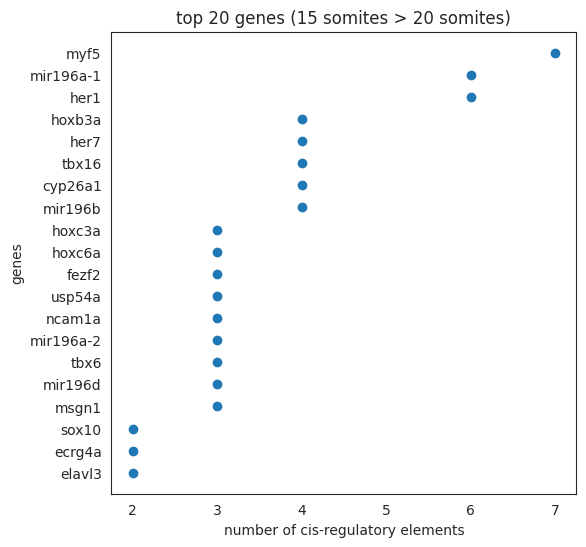

In [89]:
# 15somites > 20somites
top_genes = unique_15_20.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (15 somites > 20 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
# plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs20.png")
# plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs20.pdf")

# Display the plot
plt.show()

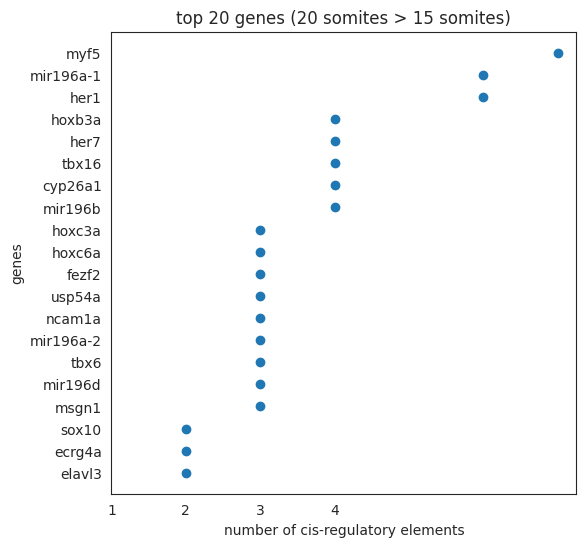

In [90]:
# 20somites > 15somites
top_genes = unique_20_15.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (20 somites > 15 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.xticks([1, 2, 3, 4])
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
# plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_20vs15.png")
# plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_20vs15.pdf")

# Display the plot
plt.show()

We can repeat this for all pairs for the comparison.

Note that we might want to make one for 15 somites stage, between two biological replicates.

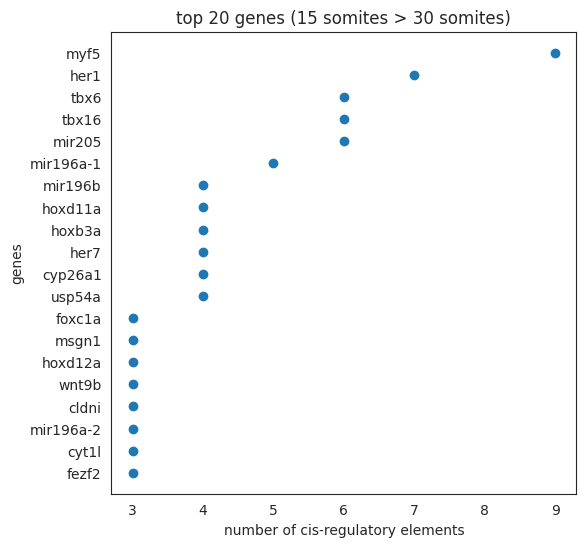

In [100]:
# 15somites > 30somites
top_genes = unique_15_30.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (15 somites > 30 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs30.png")
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_15vs30.pdf")

# Display the plot
plt.show()

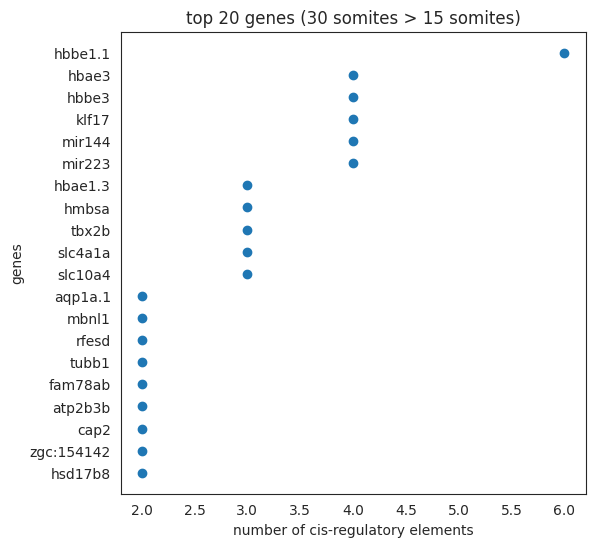

In [102]:
# 30somites > 15somites
top_genes = unique_30_15.value_counts("gene_short_name").head(20)

# Extract gene names and their counts
gene_names = top_genes.index.tolist()
counts = top_genes.values

# Create rank plot
plt.figure(figsize=(6,6))  # Adjust the figure size
plt.scatter(counts, gene_names)

# Add titles and labels
# plt.title('Top 20 Genes Rank Plot')
plt.title("top 20 genes (30 somites > 15 somites)")
plt.xlabel('number of cis-regulatory elements')
plt.ylabel('genes')
#plt.grid(axis='x')  # Add a grid on the x-axis for better readability
# Invert the y-axis order
plt.gca().invert_yaxis()

# save the figure
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_30vs15.png")
plt.savefig("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/zebrahub-multiome-analysis/figures/CCAN_comparison_timepoints/rank_top20genes_30vs15.pdf")

# Display the plot
plt.show()

## Step 2-2. Visualization of the genomic regions and CCANs

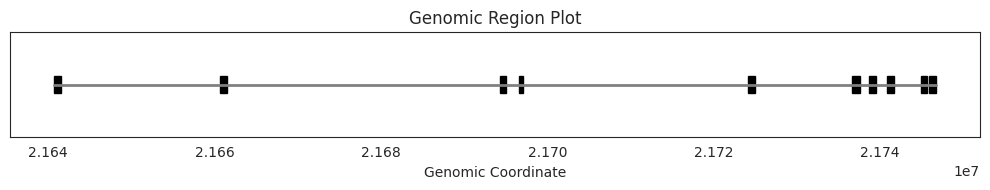

In [156]:
# visualize the genomic regions with a linear plot
import matplotlib.patches as patches

# define the gene name
gene_name = "myf5"
df = mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name]

# Parsing peak_id to get start and end coordinates
df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
df['end'] = df['peak_id'].str.split('_').str[2].astype(int)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Plotting a thin line for the genomic region
ax.plot([df['start'].min(), df['end'].max()], [1, 1], color='grey', linewidth=2)

# Adjusting the height and position of the boxes
box_height = 0.1
box_position = 1 - box_height / 2

# Plotting black boxes for each peak using rectangles
for _, row in df.iterrows():
    rect = patches.Rectangle((row['start'], box_position), row['end'] - row['start'], box_height, linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)

# Setting y-axis limits and removing y-axis ticks
ax.set_ylim(0.7, 1.3)
ax.set_yticks([])
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Genomic Region Plot')

plt.tight_layout()
plt.show()

In [ ]:
# visualize the genomic regions with a linear plot
import matplotlib.patches as patches

# define the gene name
gene_name = "myf5"
df = mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name==gene_name]

# Parsing peak_id to get start and end coordinates
df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
df['end'] = df['peak_id'].str.split('_').str[2].astype(int)

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Plotting a thin line for the genomic region
ax.plot([df['start'].min(), df['end'].max()], [1, 1], color='grey', linewidth=2)

# Adjusting the height and position of the boxes
box_height = 0.1
box_position = 1 - box_height / 2

# Plotting black boxes for each peak using rectangles
for _, row in df.iterrows():
    rect = patches.Rectangle((row['start'], box_position), row['end'] - row['start'], box_height, linewidth=1, edgecolor='black', facecolor='black')
    ax.add_patch(rect)

# Setting y-axis limits and removing y-axis ticks
ax.set_ylim(0.7, 1.3)
ax.set_yticks([])
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Genomic Region Plot')

plt.tight_layout()
plt.show()

In [7]:
# a function to plot the genomic regions
import matplotlib.patches as patches

def compute_start_end(df):
    """Function to compute start and end coordinates for a dataframe."""
    df['start'] = df['peak_id'].str.split('_').str[1].astype(int)
    df['end'] = df['peak_id'].str.split('_').str[2].astype(int)
    return df

# plot_peaks with y_base as an input argument to stagger different plots on top of each other (along the y-axis)
def plot_peaks(df, ax, y_base, color, label=None):
    """Function to plot peaks at a specified y-axis basis."""
    for _, row in df.iterrows():
        rect = patches.Rectangle((row['start'], y_base), row['end'] - row['start'], 0.1, linewidth=1, edgecolor=color, facecolor=color, label=label)
        ax.add_patch(rect)
        label = None  # Set to None to prevent repeating the label
        

def plot_peaks_with_alpha(df, ax, color, label=None):
    """Function to plot peaks with alpha for overlapping peaks."""
    for i, (_, row) in enumerate(df.iterrows()):
        # Only add label for the first rectangle of each group
        lbl = label if i == 0 else None
        rect = patches.Rectangle((row['start'], 0.9), row['end'] - row['start'], 0.2, linewidth=1, edgecolor=color, facecolor=color, alpha=0.5, label=lbl)
        ax.add_patch(rect)

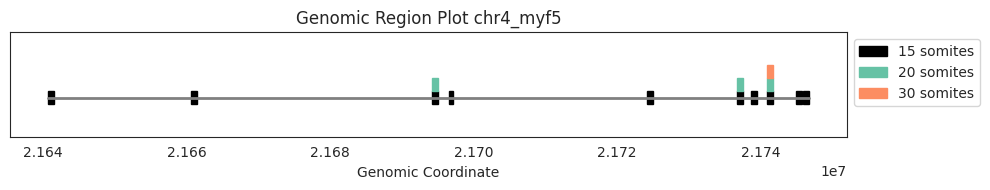

In [195]:
# Setting up color options
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
seaborn_set2 = sns.color_palette("Set2")

# Define the gene name
gene_name = "myf5"

# Define the dataframes
# 15 somites
df1 = mapped_peaks_15somites[mapped_peaks_15somites.gene_short_name == gene_name]
# 20 somites
df2 = mapped_peaks_20somites[mapped_peaks_20somites.gene_short_name == gene_name]
# 30 somites
df3 = mapped_peaks_30somites[mapped_peaks_30somites.gene_short_name == gene_name]

# Compute the start and end positions of the peaks
df1 = compute_start_end(df1)
df2 = compute_start_end(df2)
df3 = compute_start_end(df3)

# Extracting chromosome number
chromosome = df1['peak_id'].iloc[0].split('_')[0]

# Plotting
fig, ax = plt.subplots(figsize=(10, 2))

# Plotting a thin line for the genomic region
genomic_start = min(df1['start'].min(), df2['start'].min(), df3['start'].min())
genomic_end = max(df1['end'].max(), df2['end'].max(), df3['end'].max())
ax.plot([genomic_start, genomic_end], [1, 1], color='grey', linewidth=2)

# Plot peaks from df1 in black at y_base=1
plot_peaks(df1, ax, 0.95, 'black', "15 somites")

# Plot peaks from df2 in a different color, e.g., 'blue' at y_base=1.1
plot_peaks(df2, ax, 1.05, seaborn_set2[0], "20 somites")

# Plot peaks from df3 at y_base=1.3
plot_peaks(df3, ax, 1.15, seaborn_set2[1], "30 somites")

# Setting y-axis limits and removing y-axis ticks
ax.set_ylim(0.7, 1.5)
ax.set_yticks([])
ax.set_xlabel('Genomic Coordinate')
ax.set_title('Genomic Region Plot ' + chromosome + "_" + gene_name)
# Adjust the legend position and size
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 10})

plt.tight_layout()

plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".png")
plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".pdf")

plt.show()

In [8]:
# Define the timepoints
timepoints = ["0budstage", "5somites", "10somites", "15somites", "20somites", "30somites"]

# Load the "viridis" colormap
viridis = plt.cm.get_cmap('viridis', 256)

# Select a subset of the colormap to ensure that "30 somites" is yellow
# You can adjust the start and stop indices to shift the colors
start = 50
stop = 256
colors = viridis(np.linspace(start/256, stop/256, len(timepoints)))

# Create a dictionary to map timepoints to colors
color_dict = dict(zip(timepoints, colors))
color_dict

{'0budstage': array([0.255645, 0.260703, 0.528312, 1.      ]),
 '5somites': array([0.180629, 0.429975, 0.557282, 1.      ]),
 '10somites': array([0.123463, 0.581687, 0.547445, 1.      ]),
 '15somites': array([0.226397, 0.728888, 0.462789, 1.      ]),
 '20somites': array([0.575563, 0.844566, 0.256415, 1.      ]),
 '30somites': array([0.993248, 0.906157, 0.143936, 1.      ])}

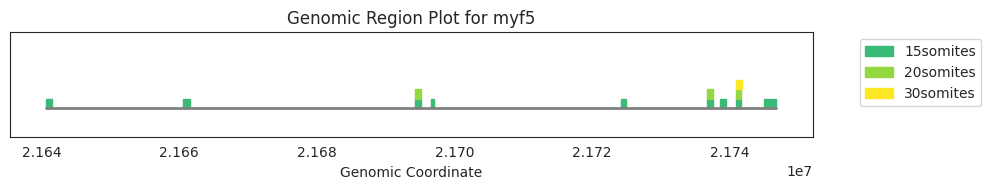

In [12]:
# Let's make the above as a function
# inputs: (1) gene_name, (2) a set of dataframes (at each timepoint)
# optional arguments (1) figpath, (2)
# workflow:
# output: a plot to save


# colormap
# Define the timepoints
timepoints = ["0budstage", "5somites", "10somites", "15somites", "20somites", "30somites"]

# Load the "viridis" colormap
viridis = plt.cm.get_cmap('viridis', 256)

# Select a subset of the colormap to ensure that "30 somites" is yellow
# You can adjust the start and stop indices to shift the colors
start = 50
stop = 256
colors = viridis(np.linspace(start/256, stop/256, len(timepoints)))

# Create a dictionary to map timepoints to colors
color_dict = dict(zip(timepoints, colors))
color_dict

# Define the gene name
gene_name = "myf5"

def plot_CCANs_genomic_loci(CCANs, timepoints, gene_name, colordict, 
                            save_fig=False, figpath = None):
    """
    Description: 
    This function takes a list of CCANs (dataframes for each timepoint), 
    plots the genomic region with CCANs for each timepoint for "gene_name".
    
    Parameters:
    1) gene_name: Name of the gene, i.e. "myf5", "her1"
    2) CCANs: A list of dataframes (one dataframe for each timepoint), i.e. [df1, df2, df3]
    3) timepoints: A list of timepoint labels corresponding to each dataframe in CCANs
    4) colordict: A dictionary of {timepoints:colors (viridis)}
    """
    
    if len(CCANs) != len(timepoints):
        raise ValueError("The number of CCANs dataframes and timepoints labels must be equal")

    # colormap - just define at the beginning (this can be replaced)
    # Define the timepoints
    all_timepoints = ["0budstage", "5somites", "10somites", "15somites", "20somites", "30somites"]

    # Load the "viridis" colormap
    viridis = plt.cm.get_cmap('viridis', 256)

    # Select a subset of the colormap to ensure that "30 somites" is yellow
    # You can adjust the start and stop indices to shift the colors
    start = 50
    stop = 256
    colors = viridis(np.linspace(start/256, stop/256, len(all_timepoints)))

    # Create a dictionary to map timepoints to colors
    color_dict = dict(zip(all_timepoints, colors))
    color_dict
    
    # generate a figure object    
    fig, ax = plt.subplots(figsize=(10, 2))
    
    genomic_start, genomic_end = float('inf'), 0

    for index, (df, stage) in enumerate(zip(CCANs, timepoints)):
        df = df[df.gene_short_name == gene_name]
        df = compute_start_end(df)
        
        genomic_start = min(genomic_start, df['start'].min())
        genomic_end = max(genomic_end, df['end'].max())
        
        plot_peaks(df, ax, 1 + index*0.1, colordict[stage], stage)
    
    ax.plot([genomic_start, genomic_end], [1, 1], color='grey', linewidth=2)
    
    ax.set_ylim(0.7, 1 + len(CCANs)*0.1 + 0.5)
    ax.set_yticks([])
    ax.set_xlabel('Genomic Coordinate')
    ax.set_title(f'Genomic Region Plot for {gene_name}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    if save_fig==True:
        plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".png")
        plt.savefig(figpath + "coverage_plot_CCANs_" + gene_name + ".pdf")
    
    plt.show()
        
        
plot_CCANs_genomic_loci([mapped_peaks_15somites, mapped_peaks_20somites, mapped_peaks_30somites],
                        gene_name="myf5", timepoints=["15somites", "20somites","30somites"], colordict=color_dict)
    


In [19]:
unique_30_15[unique_30_15.gene_short_name=="hbbe1.1"]

,peak_id,gene_short_name
192,chr3_55056951_55057792,hbbe1.1
195,chr3_55065511_55066525,hbbe1.1
196,chr3_55068869_55069565,hbbe1.1
199,chr3_55126026_55126867,hbbe1.1
202,chr3_55151396_55152191,hbbe1.1
204,chr3_55251308_55252170,hbbe1.1


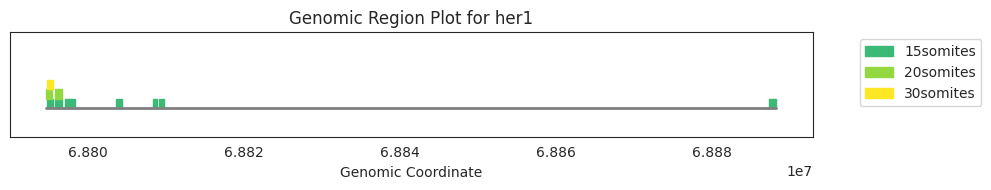

In [14]:
plot_CCANs_genomic_loci([mapped_peaks_15somites, mapped_peaks_20somites, mapped_peaks_30somites],
                        gene_name="her1", timepoints=["15somites", "20somites","30somites"], colordict=color_dict,
                        save_fig=True, figpath=figpath)

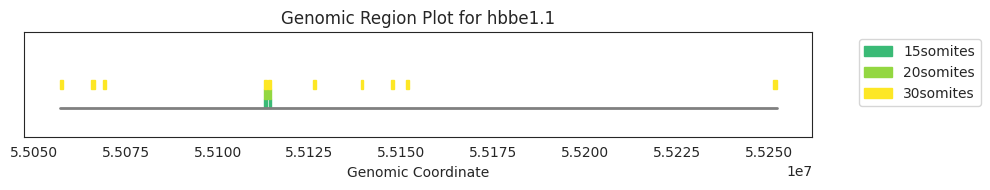

In [15]:
plot_CCANs_genomic_loci([mapped_peaks_15somites, mapped_peaks_20somites, mapped_peaks_30somites],
                        gene_name="hbbe1.1", timepoints=["15somites", "20somites","30somites"], colordict=color_dict,
                        save_fig=True, figpath=figpath)

## Additional steps:

- map out the TSS (from CellOracle's TSS database - from CisBP?)



# Step 3. Comparison of base GRNs

- [To-Do] Move this section (and forward) to another notebook (to keep things modular)

- Now, we want to compare the regulatory TFs for each gene (cis-regulatory element), especially for genes which have different cis-regulatory profiles over time. Check for the genes that have varying cis-regulatory elements, whether they exist in our base GRN (as targets, or reg.TFs). Genes without TSS annotation will be missing in our base GRN.

- 1) We will import the base GRN (which is a dataframe of peaks-by-TFs) for each timeframe.
- 2) Pick top 10-20 (or 50) genes whose cis-regulatory elements change significantly over time (from the Step 2.)
- 3) Map out the TFs that are differentially activating/repressing those genes at the base GRN level (for the top 10-50 genes)

- Let's start with "myf5" gene, whose cis-regulatory elements increases over time.

In [199]:
# Check the peaks that were in 15 somites but not in 20 somites (or 30 somites)
# Let's use "myf5" gene as an example
unique_15_20[unique_15_20.gene_short_name=="myf5"]

,peak_id,gene_short_name
116,chr4_21640698_21641565,myf5
117,chr4_21660593_21661497,myf5
118,chr4_21696596_21697063,myf5
119,chr4_21724146_21724976,myf5
120,chr4_21738624_21739481,myf5
121,chr4_21744914_21745703,myf5
122,chr4_21745860_21746718,myf5


In [52]:
baseGRN_15somites = pd.read_parquet("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/05_TDR118_base_GRN_dataframe.parquet")
baseGRN_15somites

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
0,chr10_10310135_10311044,mir219-1,0,0,1,0,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
1,chr10_10312654_10313520,urm1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,chr10_10318857_10319768,mir219-1,0,0,1,1,0,1,0,0,...,0,1,1,1,0,0,0,0,0,0
3,chr10_10330150_10331040,mir219-1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,chr10_10728430_10729439,swi5,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14506,chr9_9670995_9671898,gsk3ba,0,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
14507,chr9_9841650_9842440,fstl1b,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14508,chr9_9960217_9961167,prmt2,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
14509,chr9_9977190_9977958,ugt1a1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
baseGRN_20somites = pd.read_parquet("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR125_cicero_output/05_TDR125_base_GRN_dataframe.parquet")
baseGRN_30somites = pd.read_parquet("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR124_cicero_output/05_TDR124_base_GRN_dataframe.parquet")

In [131]:
baseGRN_cisbp = co.data.load_zebrafish_promoter_base_GRN()
baseGRN_cisbp

Loading prebuilt promoter base-GRN. Version: danRer11_CisBPv2_fpr2


,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
0,chr10_10312024_10313124,urm1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_10329454_10330554,mir219-1,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,chr10_10385573_10386673,sardh,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,chr10_10607018_10608118,dbh,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10727977_10729077,swi5,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17775,chrUn_KZ116019v1_8579_9679,klc2,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
17776,chrUn_KZ116023v1_2574_3674,zgc:153137,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
17777,chrUn_KZ116034v1_31715_32815,cd247,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
17778,chrUn_KZ116034v1_9585_9601,pou2f1a,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
baseGRN_cisbp[baseGRN_cisbp.gene_short_name=="myf5"]

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
12874,chr4_21740228_21740757,myf5,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12875,chr4_21740758_21741858,myf5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
baseGRN_15somites[baseGRN_15somites.gene_short_name=="myf5"]

,peak_id,gene_short_name,A6H8I1_DANRE,CABZ01017151.1,CABZ01056727.1,CABZ01057488.2,CABZ01066696.1,CABZ01067175.1,CABZ01079847.1,CABZ01081359.1,...,znf143b,znf148,znf281a,znf281b,znf652,znf653,znf711,znf740b,znf76,zzz3
10758,chr4_21640698_21641565,myf5,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10761,chr4_21660593_21661497,myf5,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,1,0
10762,chr4_21694264_21695059,myf5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10763,chr4_21696596_21697063,myf5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10764,chr4_21724146_21724976,myf5,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10765,chr4_21736676_21737587,myf5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10766,chr4_21738624_21739481,myf5,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10767,chr4_21740822_21741654,myf5,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
10768,chr4_21744914_21745703,myf5,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
10769,chr4_21745860_21746718,myf5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
unique_15_20[unique_15_20.gene_short_name=="myf5"]

,peak_id,gene_short_name
116,chr4_21640698_21641565,myf5
117,chr4_21660593_21661497,myf5
118,chr4_21696596_21697063,myf5
119,chr4_21724146_21724976,myf5
120,chr4_21738624_21739481,myf5
121,chr4_21744914_21745703,myf5
122,chr4_21745860_21746718,myf5


In [54]:
# example gene: 'myf5'
gene_name = "myf5"

# define a dict to save the peaks-regulatory TFs as pairs
genes_for_peak = {}

# Filter dataframe for peaks with gene_short_name as 'myf5'
filtered_df = baseGRN_15somites[baseGRN_15somites['gene_short_name'] == gene_name]

# Drop the 'gene_short_name' column as it's no longer needed for the extraction
filtered_df = filtered_df.drop(columns=['gene_short_name'])

# Extract genes with "1" for each peak
genes_for_peak = {}
for peak, row in filtered_df.iterrows():
    genes_for_peak[row.peak_id] = row.index[row == 1].tolist()

# print(genes_for_peak)


In [57]:
# example gene: 'myf5'
gene_name = "myf5"

# uniquely accessible peaks(CCANs) for the specific "gene_name"
unique_15_20_peaks = unique_15_20[unique_15_20.gene_short_name==gene_name].peak_id.to_list()
unique_15_20_peaks

shared_peaks = [peak for peak in genes_for_peak.keys() if peak not in unique_15_20_peaks]
shared_peaks

# compute the regulatory TFs from the base GRN for each peak group (unique vs shared)
regTFs_from_peaks_unique_15_20 = set(gene for peak_id in unique_15_20_peaks for gene in genes_for_peak[peak_id])

regTFs_from_peaks_shared_15_20 = set(gene for peak_id in shared_peaks for gene in genes_for_peak[peak_id])


In [62]:
# example gene: 'myf5'
gene_name = "myf5"

# uniquely accessible peaks(CCANs) for the specific "gene_name"
unique_15_30_peaks = unique_15_30[unique_15_30.gene_short_name==gene_name].peak_id.to_list()
unique_15_30_peaks

shared_peaks = [peak for peak in genes_for_peak.keys() if peak not in unique_15_30_peaks]
shared_peaks

# compute the regulatory TFs from the base GRN for each peak group (unique vs shared)
regTFs_from_peaks_unique_15_30 = set(gene for peak_id in unique_15_30_peaks for gene in genes_for_peak[peak_id])

regTFs_from_peaks_shared_15_30 = set(gene for peak_id in shared_peaks for gene in genes_for_peak[peak_id])



In [63]:
# the number of unique and shared regulatory TFs between 15 somites and 20 somites (unique in 15 compared to 20 somites)
print(len(regTFs_from_peaks_unique_15_30))
print(len(regTFs_from_peaks_shared_15_30))

670
366


In [64]:
# Now, let's take a look at the regulatory TFs that are only present in "unique" peak groups (TFs that are not present in the shared peaks)
unique_regTFs_15_30 = set(regTFs_from_peaks_unique_15_30) - set(regTFs_from_peaks_shared_15_30)
len(unique_regTFs_15_30)

328

In [106]:
len(unique_regTFs_15_20)

223

## Notes

- For the base GRN, there are too many TFs that "might" bind to the regulatory elements. (as the base GRN is merely for constructing basis for regularized linear regression for each cell-type).

- So, we will take a look at the cell-type specific GRNs at earlier and later timepoints, to see which TFs appear at specific timepoints.

- Note that the cell-type specific GRN is a combination of scATAC-seq (base GRN) and scRNA-seq (gene expression for linear regression for the edge width), we won't be able to de-couple the base GRN effect.

- To account for this, we will use the list of regulatory TFs that are unique in one timepoint versus the other timepoint.

- test with 15 somites vs 20 somites

In [100]:
# An example of cis-regulatory elements increase and decrease (dynamic) during the development.

# gene_name = "myog"
# print(unique_15_20[unique_15_20.gene_short_name==gene_name])
# print(unique_20_30[unique_20_30.gene_short_name==gene_name])
# print(unique_15_30[unique_15_30.gene_short_name==gene_name])

Empty DataFrame
Columns: [peak_id, gene_short_name]
Index: []
                     peak_id gene_short_name
192  chr11_22544195_22545006            myog
193  chr11_22578597_22579479            myog
194  chr11_22605698_22606577            myog
195  chr11_22608640_22609509            myog
196  chr11_22611484_22612314            myog
                     peak_id gene_short_name
218  chr11_22578568_22579469            myog
219  chr11_22608633_22609498            myog


# Step 4. Check the unique regulatory TFs in cell-type specific GRNs (either filtered or unfiltered)

- 1) myf5 is one of the unique TFs in the early cis-regulatory elements for gene_name="myf5". Do we get to see some auto-regulatory network for this gene?
- 2) What are the TFs that regulate myf5 (in some cell-types), that are only present in "unique" cis-regulatory elements from 15 somites stage?

## **NOTE: I need to understand deeply on how the linear regression step is done - for example, when there are multiple peaks for a target gene, with duplicated TF motifs, are they "weighted", or are they just summed for a master list of TFs for linear regression?**



## NOTES:

So, there's no "myf5" gene from our adata object (3K highly variable genes), and that affected our GRN as well.

- Since CellOracle strongly recommends filtering the adata for highly variable genes. The reasoning is that the non-HVG are not going to contribute to the "differential" gene expression between cell-types. The 3000 genes (or 2000) seems a little arbitrary, so we might want to add some of the TFs back, especially those are already present in our base GRN (to capture potential auto-regulatory relationships).

- We will have to re-compute the cell-type specific GRNs (and anything downstream - such as in silico KO, or even network motif detection, etc.)

In [141]:
# check the Links object
Links_15somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_celloracle_allTFs/08_TDR118_HVG_HVCG_celltype_GRNs.celloracle.links")
Links_15somites

Links_15somites_HVG = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR118_cicero_output/08_TDR118_celltype_GRNs.celloracle.links")
Links_15somites_HVG
# oracle_20somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR125_cicero_output/06_TDR125.celloracle.oracle")
# oracle_20somites

In [21]:
Links_15somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/08_TDR119_celltype_GRNs.celloracle.links")
Links_20somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR125_cicero_output/08_TDR125_celltype_GRNs.celloracle.links")
Links_30somites = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR124_cicero_output/08_TDR124_celltype_GRNs.celloracle.links")


In [38]:
# extract the raw GRNs for "PSM" (as PSM has the highest expression of myf5 gene - at least in 15 somites stage)
df_raw_links_PSM_15somites = Links_15somites.links_dict["PSM"]
df_raw_links_PSM_20somites = Links_20somites.links_dict["PSM"]
df_raw_links_PSM_30somites = Links_30somites.links_dict["PSM"]

In [44]:
regTFs_myf5_15somites = df_raw_links_PSM_15somites[df_raw_links_PSM_15somites.target=="myf5"].source.to_list()
# regTFs_myf5_15somites
regTFs_myf5_20somites = df_raw_links_PSM_20somites[df_raw_links_PSM_20somites.target=="myf5"].source.to_list()
regTFs_myf5_30somites = df_raw_links_PSM_30somites[df_raw_links_PSM_30somites.target=="myf5"].source.to_list()

In [66]:
# reg TFs from the base GRN - that were identified to be only present in "unique" peaks from 15 somites, compared to 30 somites
# unique_regTFs_15_30

In [68]:
df1

,source,target,coef_mean,coef_abs,p,-logp
114949,pax1a,myf5,-0.001634,0.001634,1.811071e-04,3.742064
114950,otpb,myf5,-0.000540,0.000540,3.638129e-02,1.439122
114951,etv1,myf5,-0.003795,0.003795,7.636525e-07,6.117104
114952,foxg1a,myf5,-0.000852,0.000852,3.503322e-03,2.455520
114953,tfap2a,myf5,-0.001222,0.001222,1.435113e-05,4.843114
...,...,...,...,...,...,...
115204,nkx2.5,myf5,-0.000720,0.000720,1.016019e-02,1.993098
115205,meox1,myf5,0.009746,0.009746,1.313311e-14,13.881632
115206,meis1b,myf5,-0.001300,0.001300,1.543175e-03,2.811585
115207,scrt2,myf5,-0.000468,0.000468,6.679823e-03,2.175235


In [70]:
df1[df1.source=="myf5"]

,source,target,coef_mean,coef_abs,p,-logp


In [74]:
df1[df1.source.isin(unique_regTFs_15_30)].sort_values("coef_abs", ascending=False)

,source,target,coef_mean,coef_abs,p,-logp
115106,myod1,myf5,0.008723,0.008723,4.947138e-14,13.305646
115062,esrrga,myf5,-0.008197,0.008197,4.464765e-15,14.350201
115052,zbtb18,myf5,0.007040,0.007040,1.336268e-11,10.874107
115174,tbx16,myf5,0.006348,0.006348,5.562416e-10,9.254737
115141,mef2d,myf5,0.005729,0.005729,2.336863e-11,10.631367
...,...,...,...,...,...,...
115184,isl1l,myf5,0.000127,0.000127,4.287167e-01,0.367830
115200,fosb,myf5,-0.000123,0.000123,5.678217e-01,0.245788
115181,cebpd,myf5,-0.000041,0.000041,8.960334e-01,0.047676
115109,nkx2.2b,myf5,0.000012,0.000012,9.569964e-01,0.019090


In [77]:
df1.sort_values("coef_abs", ascending=False)[0:20]

,source,target,coef_mean,coef_abs,p,-logp
115205,meox1,myf5,0.009746,0.009746,1.313311e-14,13.881632
115106,myod1,myf5,0.008723,0.008723,4.947138e-14,13.305646
115062,esrrga,myf5,-0.008197,0.008197,4.464765e-15,14.350201
115052,zbtb18,myf5,0.007040,0.007040,1.336268e-11,10.874107
115068,raraa,myf5,0.006600,0.006600,6.144120e-12,11.211540
115022,hoxa11b,myf5,0.006446,0.006446,1.128351e-14,13.947556
115174,tbx16,myf5,0.006348,0.006348,5.562416e-10,9.254737
115141,mef2d,myf5,0.005729,0.005729,2.336863e-11,10.631367
114955,emx3,myf5,-0.005011,0.005011,6.047184e-10,9.218447
115064,en1b,myf5,0.004473,0.004473,2.733137e-12,11.563339


In [75]:
df1[df1.source.isin(unique_regTFs_15_30)].sort_values("coef_abs", ascending=False)[0:20]

,source,target,coef_mean,coef_abs,p,-logp
115106,myod1,myf5,0.008723,0.008723,4.947138e-14,13.305646
115062,esrrga,myf5,-0.008197,0.008197,4.464765e-15,14.350201
115052,zbtb18,myf5,0.007040,0.007040,1.336268e-11,10.874107
115174,tbx16,myf5,0.006348,0.006348,5.562416e-10,9.254737
115141,mef2d,myf5,0.005729,0.005729,2.336863e-11,10.631367
114971,smad3a,myf5,0.003837,0.003837,1.917754e-09,8.717207
114951,etv1,myf5,-0.003795,0.003795,7.636525e-07,6.117104
115149,mafbb,myf5,-0.003564,0.003564,4.720514e-10,9.326011
115020,zic2b,myf5,0.003492,0.003492,1.013758e-11,10.994066
115043,tbx18,myf5,-0.003451,0.003451,2.927011e-11,10.533576


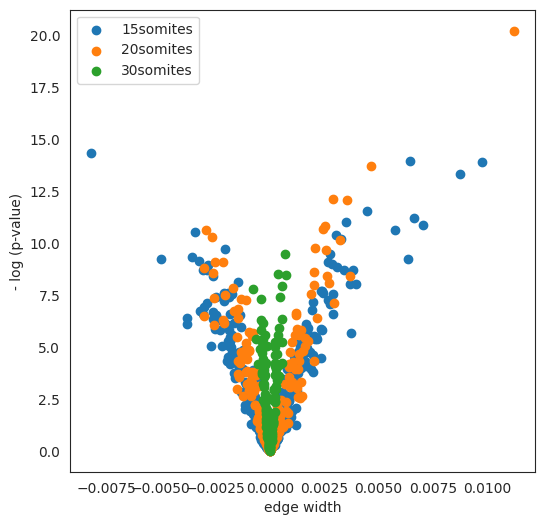

In [61]:
df1 = df_raw_links_PSM_15somites[df_raw_links_PSM_15somites.target=="myf5"]
df1
df2 = df_raw_links_PSM_20somites[df_raw_links_PSM_20somites.target=="myf5"]
df3 = df_raw_links_PSM_30somites[df_raw_links_PSM_30somites.target=="myf5"]

plt.scatter(df1["coef_mean"], df1["-logp"])
plt.scatter(df2["coef_mean"], df2["-logp"])
plt.scatter(df3["coef_mean"], df3["-logp"])
plt.legend(["15somites", "20somites", "30somites"])
plt.xlabel("edge width")
plt.ylabel("- log (p-value)")

plt.savefig(figpath+"/raw_GRN_myf5_15_20_30somites.pdf")

In [45]:
set(regTFs_myf5_15somites) - set(regTFs_myf5_30somites)

{'ar',
 'arid5b',
 'atf3',
 'bhlha15',
 'bhlhe22',
 'cebpa',
 'cebpb',
 'cebpd',
 'creb5b',
 'cux2b',
 'dlx4a',
 'dmrt2a',
 'dmrt2b',
 'dmrta2',
 'drgx',
 'ebf3b',
 'elk3',
 'esrrga',
 'etv1',
 'etv2',
 'etv4',
 'fli1a',
 'fli1b',
 'fosaa',
 'fosb',
 'foxa2',
 'foxd5',
 'foxf1',
 'foxi3a',
 'foxi3b',
 'foxj1a',
 'foxn3',
 'foxo3b',
 'foxp4',
 'gata1a',
 'gata2a',
 'gata5',
 'gata6',
 'gbx1',
 'gbx2',
 'gcm2',
 'gfi1aa',
 'gfi1ab',
 'gfi1b',
 'gli2a',
 'gli3',
 'hmga1a',
 'hmga2',
 'hmx2',
 'hnf1ba',
 'hnf1bb',
 'hnf4a',
 'hoxa10b',
 'hoxa9b',
 'hoxb7a',
 'hoxc10a',
 'hoxc11a',
 'hoxc13b',
 'hoxc1a',
 'hoxc8a',
 'hoxd3a',
 'hoxd9a',
 'irx1b',
 'irx3a',
 'irx3b',
 'irx7',
 'isl1',
 'isl1l',
 'isl2b',
 'jun',
 'klf12a',
 'klf12b',
 'lef1',
 'lhx1b',
 'lhx2a',
 'lmx1a',
 'lmx1al',
 'lmx1ba',
 'lmx1bb',
 'mafba',
 'mef2aa',
 'mef2b',
 'mef2ca',
 'mef2cb',
 'mef2d',
 'meis1a',
 'meis1b',
 'meis2a',
 'meis3',
 'mitfb',
 'mnx1',
 'mnx2a',
 'msx2b',
 'msx3',
 'myod1',
 'nfatc1',
 'nfia',
 'nfic

In [29]:
Links_20somites.filtered_links["PSM"][Links_20somites.filtered_links["PSM"].source=="myf5"]

,source,target,coef_mean,coef_abs,p,-logp
7675,myf5,apoc1,0.066280,0.066280,3.065331e-14,13.513523
41686,myf5,efnb2b,0.027548,0.027548,2.649548e-17,16.576828
131598,myf5,serpinh1b,0.023214,0.023214,3.498947e-14,13.456063
110088,myf5,pcdh8,0.017354,0.017354,1.616938e-08,7.791307
63348,myf5,hbbe3,-0.012974,0.012974,5.653709e-12,11.247667
61679,myf5,gse1,0.012808,0.012808,9.470224e-14,13.023640
86310,myf5,mef2d,0.012585,0.012585,2.197521e-12,11.658067


In [31]:
Links_30somites.filtered_links["PSM"][Links_30somites.filtered_links["PSM"].source=="myf5"]

,source,target,coef_mean,coef_abs,p,-logp
147608,myf5,tenm4,-0.00696,0.00696,0.000668,3.175375


In [159]:
# Check all GRN edges for a gene of interest (as the target) - filtered GRN

# define a gene of interest (target)
gene_name = "myf5"

# Loop through all cell types
for celltype in Links_15somites.filtered_links.keys():
    df = Links_15somites.filtered_links[celltype][Links_15somites.filtered_links[celltype].target==gene_name]
    print(df)

Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empt

In [161]:
# Check all GRN edges for a gene of interest (as the target) - unfiltered GRN

# define a gene of interest (target)
gene_name = "myf5"

# Loop through all cell types
for celltype in Links_15somites.links_dict.keys():
    df = Links_15somites.links_dict[celltype][Links_15somites.links_dict[celltype].target==gene_name]
    print(df)

         source target  coef_mean  coef_abs             p      -logp
124022   creb5b   myf5   0.000007  0.000007  9.130234e-01   0.039518
124023    mef2b   myf5  -0.000557  0.000557  4.823589e-04   3.316630
124024  bcl11ab   myf5  -0.000107  0.000107  8.551269e-02   1.067969
124025   foxp1b   myf5  -0.000422  0.000422  5.340800e-04   3.272394
124026   nkx6.1   myf5   0.001621  0.001621  1.117407e-09   8.951789
...         ...    ...        ...       ...           ...        ...
124294   hoxc3a   myf5   0.001775  0.001775  7.030018e-13  12.153044
124295    nr2e1   myf5   0.000168  0.000168  1.350991e-01   0.869348
124296      pnx   myf5   0.000514  0.000514  1.050792e-03   2.978483
124297    fli1b   myf5  -0.000079  0.000079  3.465668e-01   0.460213
124298   pknox2   myf5  -0.000371  0.000371  2.548031e-04   3.593795

[277 rows x 6 columns]
         source target  coef_mean  coef_abs         p     -logp
124022   creb5b   myf5   0.000309  0.000309  0.005772  2.238667
124023    mef2b   my

In [162]:
# Let's check out the "unfiltered" GRN
celltype = "PSM"
gene_name = "myf5"
df = Links_15somites.links_dict[celltype][Links_15somites.links_dict[celltype].target==gene_name]
df

,source,target,coef_mean,coef_abs,p,-logp
124022,creb5b,myf5,0.001003,0.001003,1.116021e-04,3.952328
124023,mef2b,myf5,-0.000777,0.000777,1.324784e-02,1.877855
124024,bcl11ab,myf5,-0.000137,0.000137,6.987439e-01,0.155682
124025,foxp1b,myf5,-0.000351,0.000351,1.584702e-01,0.800052
124026,nkx6.1,myf5,-0.001329,0.001329,4.755597e-04,3.322795
...,...,...,...,...,...,...
124294,hoxc3a,myf5,0.001126,0.001126,2.012847e-04,3.696189
124295,nr2e1,myf5,0.002398,0.002398,7.563481e-09,8.121278
124296,pnx,myf5,-0.001315,0.001315,7.669920e-09,8.115209
124297,fli1b,myf5,0.000744,0.000744,8.751983e-04,3.057894


In [164]:
# Now, let's check if some of the "source" (regulatory TFs) are from the "unique" cis-regulatory elements
list_unique_TFs_PSM_myf5 = []

for TF in df.source:
    if TF in unique_regTFs_15_20:
        list_unique_TFs_PSM_myf5.append(TF)
    else:
        pass
list_unique_TFs_PSM_myf5

['creb5b',
 'mef2b',
 'bcl11ab',
 'nkx6.1',
 'im:7142702',
 'twist1b',
 'mef2ca',
 'etv2',
 'isl1',
 'isl1l',
 'irx3a',
 'zic2b',
 'scrt2',
 'etv1',
 'tbx2b',
 'foxn3',
 'spi1b',
 'mef2cb',
 'mef2aa',
 'nhlh2',
 'pbx1b',
 'fosb',
 'pbx3b',
 'meis2a',
 'scrt1a',
 'dmrt2a',
 'tbx2a',
 'hnf1bb',
 'pbx1a',
 'fosaa',
 'meis1a',
 'elk3',
 'gfi1ab',
 'six1b',
 'egr2a',
 'vsx2',
 'egr4',
 'tal1',
 'six1a',
 'jun',
 'sp7',
 'meis3',
 'si:dkey-43p13.5',
 'irx7',
 'myog',
 'fli1a',
 'zbtb18',
 'dmrt2b',
 'twist1a',
 'gfi1b',
 'irx3b',
 'smad3a',
 'gfi1aa',
 'osr1',
 'tbx4',
 'cux2b',
 'meis1b',
 'etv4',
 'mafba',
 'mef2d',
 'bcl11aa',
 'mafbb',
 'hnf1ba',
 'isl2b',
 'egr2b',
 'tbx3a',
 'six4b',
 'egr3',
 'tead1b',
 'foxo3b',
 'six2a',
 'irx1b',
 'myod1',
 'dmrta2',
 'arid5b',
 'twist2',
 'nfatc1',
 'nr2e1',
 'fli1b',
 'pknox2']

Text(0, 0.5, '-log (p-value)')

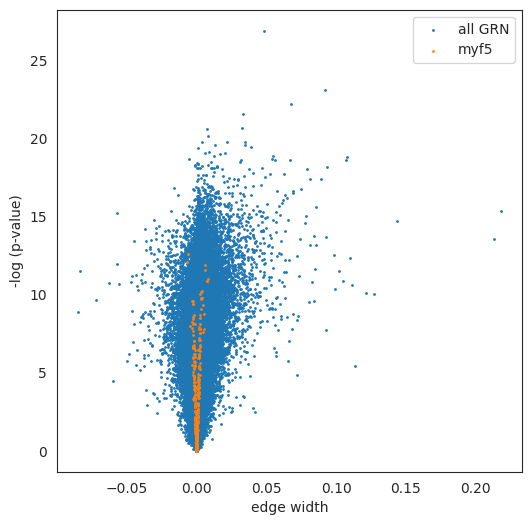

In [177]:
# Check the volcano plot for GRN "filtering" process
Links_15somites.links_dict["PSM"]

plt.scatter(Links_15somites.links_dict["PSM"].coef_mean, Links_15somites.links_dict["PSM"]["-logp"], s=1)
plt.scatter(df.coef_mean, df["-logp"],s=1)
plt.legend(["all GRN", "myf5"])
plt.xlabel("edge width")
plt.ylabel("-log (p-value)")

## NOTES:

- So, it's not as exciting as we hoped. There are genes whose cis-regulatory elements (CCANs) change over time, but they don't contribute that much to our GRN. (very small edge widths)

- However, if we want to understand the regulatory relationships of those genes, this is definitely an interesting example.

- So, even after the CellOracle computing with HVCGs in scRNA-seq data, some genes were missing (i.e. "myf5")


# 11/2/2023  - checking TDR119

- So, we learned that the TDR118 has a lower GEX sequencing depth (2/7, compared to the TDR119's GEX), hence that could have been a reason to miss some key genes (i.e. "myf5").



In [190]:
# check the Links object (TDR119, with better GEX data than TDR118, more seq-depth)
Links_15somites_TDR119 = co.load_hdf5("/hpc/projects/data.science/yangjoon.kim/zebrahub_multiome/data/processed_data/TDR119_cicero_output/08_TDR119_celltype_GRNs.celloracle.links")
Links_15somites_TDR119

In [191]:
Links_15somites_TDR119.filtered_links

{'Adaxial_Cells':         source            target  coef_mean  coef_abs             p      -logp
 165686  hmga1a  si:ch73-281n10.2   0.102975  0.102975  9.175591e-13  12.037366
 153976  hmga1a             rpl7a   0.098991  0.098991  1.182754e-13  12.927106
 203625   sox13           zbtb16a   0.075005  0.075005  1.322159e-12  11.878716
 171219   fezf1             slit3   0.070528  0.070528  2.155617e-13  12.666428
 203617    rfx4           zbtb16a   0.069373  0.069373  2.059796e-09   8.686176
 ...        ...               ...        ...       ...           ...        ...
 24224     hic1              cdon   0.010628  0.010628  2.232914e-07   6.651128
 161965    nfic              sgcd   0.010628  0.010628  2.360342e-16  15.627025
 40773    pax6a              dag1   0.010626  0.010626  1.499975e-09   8.823916
 136221  hoxb7a             pcdh8   0.010625  0.010625  2.345336e-11  10.629795
 105613   smad1             mafbb   0.010621  0.010621  2.877151e-11  10.541037
 
 [2000 rows x 6 colum

In [193]:
# Check all GRN edges for a gene of interest (as the target) - filtered GRN

# define a gene of interest (target)
gene_name = "myf5"

# Loop through all cell types
for celltype in Links_15somites_TDR119.filtered_links.keys():
    df = Links_15somites_TDR119.filtered_links[celltype][Links_15somites_TDR119.filtered_links[celltype].target==gene_name]
    print(df)

Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empty DataFrame
Columns: [source, target, coef_mean, coef_abs, p, -logp]
Index: []
Empt

In [194]:
# Check all GRN edges for a gene of interest (as the target) - unfiltered GRN

# define a gene of interest (target)
gene_name = "myf5"

# Loop through all cell types
for celltype in Links_15somites_TDR119.links_dict.keys():
    df = Links_15somites_TDR119.links_dict[celltype][Links_15somites_TDR119.links_dict[celltype].target==gene_name]
    print(df)

        source target  coef_mean  coef_abs             p      -logp
114949   pax1a   myf5   0.000717  0.000717  8.688783e-06   5.061041
114950    otpb   myf5   0.000030  0.000030  8.093319e-01   0.091873
114951    etv1   myf5  -0.000773  0.000773  1.987692e-04   3.701651
114952  foxg1a   myf5  -0.000005  0.000005  9.618865e-01   0.016876
114953  tfap2a   myf5  -0.000274  0.000274  1.326871e-04   3.877171
...        ...    ...        ...       ...           ...        ...
115204  nkx2.5   myf5  -0.000719  0.000719  1.937329e-02   1.712797
115205   meox1   myf5   0.003477  0.003477  4.751065e-13  12.323209
115206  meis1b   myf5   0.000571  0.000571  7.524867e-04   3.123501
115207   scrt2   myf5   0.000087  0.000087  4.411872e-01   0.355377
115208  scrt1a   myf5   0.001157  0.001157  1.222709e-06   5.912677

[260 rows x 6 columns]
        source target  coef_mean  coef_abs             p     -logp
114949   pax1a   myf5   0.001967  0.001967  1.587418e-09  8.799309
114950    otpb   myf5   0.

## NOTES:

So, the "myf5" regulatory GRN is very weak, but is present in TDR119, suggesting that the expression of "myf5" was high enough to be counted as HVG (highly-variable genes).

**(As of 11/2/2023, This makes me re-visit the idea that sequencing depth matters or not. Now I think that the sequencing depth matters.**

In [196]:
# Let's check out the "unfiltered" GRN
celltype = "PSM"
gene_name = "myf5"
df = Links_15somites_TDR119.links_dict[celltype][Links_15somites_TDR119.links_dict[celltype].target==gene_name]
df

# # Now, let's check if some of the "source" (regulatory TFs) are from the "unique" cis-regulatory elements
# list_unique_TFs_PSM_myf5 = []

# for TF in df.source:
#     if TF in unique_regTFs_15_20:
#         list_unique_TFs_PSM_myf5.append(TF)
#     else:
#         pass
# list_unique_TFs_PSM_myf5

,source,target,coef_mean,coef_abs,p,-logp
114949,pax1a,myf5,-0.001634,0.001634,1.811071e-04,3.742064
114950,otpb,myf5,-0.000540,0.000540,3.638129e-02,1.439122
114951,etv1,myf5,-0.003795,0.003795,7.636525e-07,6.117104
114952,foxg1a,myf5,-0.000852,0.000852,3.503322e-03,2.455520
114953,tfap2a,myf5,-0.001222,0.001222,1.435113e-05,4.843114
...,...,...,...,...,...,...
115204,nkx2.5,myf5,-0.000720,0.000720,1.016019e-02,1.993098
115205,meox1,myf5,0.009746,0.009746,1.313311e-14,13.881632
115206,meis1b,myf5,-0.001300,0.001300,1.543175e-03,2.811585
115207,scrt2,myf5,-0.000468,0.000468,6.679823e-03,2.175235


Text(0, 0.5, '-log (p-value)')

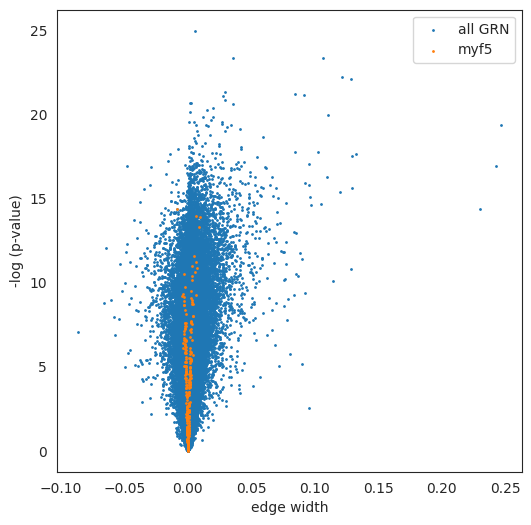

In [197]:
# Check the volcano plot for GRN "filtering" process
Links_15somites_TDR119.links_dict["PSM"]

plt.scatter(Links_15somites_TDR119.links_dict["PSM"].coef_mean, Links_15somites_TDR119.links_dict["PSM"]["-logp"], s=1)
plt.scatter(df.coef_mean, df["-logp"],s=1)
plt.legend(["all GRN", "myf5"])
plt.xlabel("edge width")
plt.ylabel("-log (p-value)")

In [195]:
# Let's check out the "unfiltered" GRN
celltype = "PSM"
gene_name = "myf5"
df = Links_15somites_TDR119.links_dict[celltype][Links_15somites_TDR119.links_dict[celltype].target==gene_name]
df

# check the top 20 regulatory TFs (both activators and repressors)
df.sort_values("coef_abs", ascending=False)[0:20]

,source,target,coef_mean,coef_abs,p,-logp
115205,meox1,myf5,0.009746,0.009746,1.313311e-14,13.881632
115106,myod1,myf5,0.008723,0.008723,4.947138e-14,13.305646
115062,esrrga,myf5,-0.008197,0.008197,4.464765e-15,14.350201
115052,zbtb18,myf5,0.007040,0.007040,1.336268e-11,10.874107
115068,raraa,myf5,0.006600,0.006600,6.144120e-12,11.211540
115022,hoxa11b,myf5,0.006446,0.006446,1.128351e-14,13.947556
115174,tbx16,myf5,0.006348,0.006348,5.562416e-10,9.254737
115141,mef2d,myf5,0.005729,0.005729,2.336863e-11,10.631367
114955,emx3,myf5,-0.005011,0.005011,6.047184e-10,9.218447
115064,en1b,myf5,0.004473,0.004473,2.733137e-12,11.563339


In [189]:
df.sort_values("coef_abs", ascending=False)[0:20].source.to_list()

['etv4',
 'hmga1a',
 'nr2f5',
 'tbx16',
 'meis1a',
 'meis1b',
 'sox6',
 'hoxb3a',
 'sox5',
 'foxc1a',
 'uncx',
 'foxp4',
 'en2b',
 'rarga',
 'nr2f1b',
 'alx4a',
 'elk3',
 'pax6b',
 'vsx1',
 'dlx3b']

In [187]:
# Let's check out the "unfiltered" GRN
celltype = "PSM"
gene_name = "meox1"
df = Links_15somites.links_dict[celltype][Links_15somites.links_dict[celltype].target==gene_name]
df

# check the top 20 regulatory TFs (both activators and repressors)
df.sort_values("coef_abs", ascending=False)[0:20]

,source,target,coef_mean,coef_abs,p,-logp
116207,etv4,meox1,0.046509,0.046509,9.632833e-18,17.016246
116164,hmga1a,meox1,0.042909,0.042909,6.991497e-16,15.155430
116206,nr2f5,meox1,0.034024,0.034024,9.575960e-11,10.018818
116228,tbx16,meox1,-0.033164,0.033164,1.291228e-13,12.888997
116140,meis1a,meox1,0.031231,0.031231,1.362554e-10,9.865646
116208,meis1b,meox1,0.028907,0.028907,2.210653e-10,9.655479
116110,sox6,meox1,-0.026434,0.026434,6.484750e-12,11.188107
116197,hoxb3a,meox1,0.025666,0.025666,4.123255e-10,9.384760
116249,sox5,meox1,0.024805,0.024805,5.765173e-13,12.239188
116183,foxc1a,meox1,0.023409,0.023409,1.183206e-15,14.926940


In [166]:
df_PSM_15somites = Links_15somites.filtered_links["PSM"]
df_PSM_15somites

# gene name
gene_name = "myf5"

print(df_PSM_15somites[df_PSM_15somites.source==gene_name])

print(df_PSM_15somites[df_PSM_15somites.target==gene_name])

,source,target,coef_mean,coef_abs,p,-logp
124022,creb5b,myf5,0.001003,0.001003,1.116021e-04,3.952328
124023,mef2b,myf5,-0.000777,0.000777,1.324784e-02,1.877855
124024,bcl11ab,myf5,-0.000137,0.000137,6.987439e-01,0.155682
124025,foxp1b,myf5,-0.000351,0.000351,1.584702e-01,0.800052
124026,nkx6.1,myf5,-0.001329,0.001329,4.755597e-04,3.322795
...,...,...,...,...,...,...
124294,hoxc3a,myf5,0.001126,0.001126,2.012847e-04,3.696189
124295,nr2e1,myf5,0.002398,0.002398,7.563481e-09,8.121278
124296,pnx,myf5,-0.001315,0.001315,7.669920e-09,8.115209
124297,fli1b,myf5,0.000744,0.000744,8.751983e-04,3.057894


In [147]:
df_subset = df_PSM_15somites[df_PSM_15somites.source==gene_name]
df_subset

,source,target,coef_mean,coef_abs,p,-logp
9053,myf5,apoc1,0.037023,0.037023,1.079233e-10,9.966885
167056,myf5,rps20,0.035168,0.035168,4.063624e-10,9.391087
158051,myf5,qkia,0.035125,0.035125,2.101988e-14,13.677370
53287,myf5,efnb2b,0.030132,0.030132,2.817400e-12,11.550152
138592,myf5,nucks1a,0.023397,0.023397,2.206118e-14,13.656371
159869,myf5,raraa,0.023349,0.023349,3.642034e-12,11.438656
121971,myf5,msgn1,0.023245,0.023245,4.683377e-13,12.329441
115507,myf5,mef2d,0.023047,0.023047,1.175753e-05,4.929684
78757,myf5,h3f3d,0.020149,0.020149,7.275081e-13,12.138162
207817,myf5,tmsb4x,0.020031,0.020031,9.227631e-07,6.034910


In [236]:
Links_20somites.filtered_links["PSM"]

,source,target,coef_mean,coef_abs,p,-logp
24535,egr2b,cirbpa,0.146845,0.146845,6.719124e-18,17.172687
24514,klf6a,cirbpa,0.120001,0.120001,3.198143e-13,12.495102
24539,klf17,cirbpa,0.112417,0.112417,1.538172e-14,13.812995
139668,creb5b,slit3,0.110357,0.110357,1.018092e-10,9.992213
66349,rxraa,hmgb2a,-0.105660,0.105660,9.311670e-15,14.030972
...,...,...,...,...,...,...
53822,meox1,foxp4,-0.012382,0.012382,3.227934e-13,12.491075
107889,nr2f1b,pax6a,0.012381,0.012381,3.821035e-10,9.417819
85166,lhx2b,marcksl1b,-0.012381,0.012381,7.051622e-07,6.151711
159228,en2b,tuba1a,0.012375,0.012375,1.489846e-08,7.826859


## [Deprecated] side note: check the cicero co-access score threshold for "myf5". 

We have only TSS for myf5 at 0 somites stage, and then lots of highly co-accessible peaks to TSS at the 5 somites stage.
We want to make sure if this is biologically true, or if it's an artifact from the co-access score cutoff (0.8 used in CellOracle pipeline).

In [26]:
# for a given gene, we will plot the genomic region with all co-accessible peaks
# input parameters: peak_pairs, threshold_coaccess, [optional] genomic_range
df_peak_list = datasets_cicero["TDR126_cicero"]["peak_lists"]
df_peak_pairs = datasets_cicero["TDR126_cicero"]["peak_pairs"]
df_peaks_TSS_mapped = datasets_cicero["TDR126_cicero"]["filtered_peaks"]

In [27]:
df_peak_list.head()

,x
1,1-3615-3873
2,1-4489-6249
3,1-9612-9969
4,1-11013-12895
5,1-14637-15105


In [28]:
df_peak_list[df_peak_list.x.str.startswith("4-2174")]

,x
52083,4-21740907-21741696
52084,4-21743122-21743440
52085,4-21745079-21745503
52086,4-21745791-21746519


In [36]:
# # for a given gene, we will plot the genomic region with all co-accessible peaks
# # input parameters: peak_pairs, threshold_coaccess, [optional] genomic_range
# df_peak_list = datasets_cicero["TDR118reseq_cicero"]["peak_lists"]
# df_peak_pairs = datasets_cicero["TDR118reseq_cicero"]["peak_pairs"]
# df_peaks_TSS_mapped = datasets_cicero["TDR118reseq_cicero"]["filtered_peaks"]


In [30]:
df_peaks_TSS_mapped.head()

,peak_id,gene_short_name
0,chr10_10310069_10310808,mir219-1
1,chr10_10312861_10313479,urm1
2,chr10_10318867_10319654,mir219-1
3,chr10_10326182_10326642,mir219-1
4,chr10_10330100_10330858,mir219-1


In [31]:
# extract the gene's TSS (in this case, there's only one TSS-mapped peak, which is TSS itself)
TSS_coord = df_peaks_TSS_mapped[df_peaks_TSS_mapped.gene_short_name=="myf5"]["peak_id"].values

TSS_coord = "chr4_21740907_21741696"

In [33]:
# reformat the TSS peak format
TSS_coord = "4-21740907-21741696"


In [34]:
df_peak_pairs[df_peak_pairs.Peak2==TSS_coord].head()

,Peak1,Peak2,coaccess
